In [1]:
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np
import h5py
import hdf5plugin
import ray
import pickle
import multiprocessing
from functools import partial
import matplotlib.pyplot as plt
import os, sys

from collections import Counter
from scipy.interpolate import interp1d


sys.path.append(os.getcwd()+'/../../public/cds-backend/code/')
import cds_eua4 as eua

!module load odc
import pyodc
# import codc

from scipy.stats import linregress


/srvfs/home/uvoggenberger/micromamba/envs/uv12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-15 11:17:15,656	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


no config found
Loading odc/1.4.5-gcc-11.3.0-avoxopw
  Loading requirement: openmpi/4.0.5-gcc-11.3.0-pob76hu
    eckit/1.24.4-gcc-11.3.0-jxjc4by
>

In [2]:
def find_closest_date(dates, target):
    return dates.loc[(dates - target).abs().idxmin()]

def calculate_pressure_layered(p0, L, T, z, R=287.053, g=9.80665):
    """
    Calculate the pressure (p) layer by layer for a given atmosphere model.
    
    Parameters:
    - p0: float, pressure at the start of the first layer (in Pascals)
    - L: list of float, temperature lapse rates for each layer (in K/m)
    - z: list of float, thickness of each layer (in meters)
    - T: list of float, temperature at the start of each layer (in Kelvin)
    - R: float, specific gas constant for dry air (default: 287.053 J/(kg·K))
    - g: float, acceleration due to gravity (default: 9.80665 m/s²)
    
    Returns:
    - list of float, pressures at the end of each layer
    """
    p_out = [] 

    exponent = g / (L * R) 

    for i in range(len(z)):
        if i == 0:
            p_out.append(p0)
        else:
            if np.abs(L[i]) > 0.001:  # If L is non-zero, use the polytropic formula
                p_next = p_out[i-1] * (1 - (L[i] * (z[i] - z[i-1])) / (T[i])) ** exponent[i]
            else:  # If L close to 0, use the isothermal layer formula
                p_next = p_out[i-1] * np.exp(-g * (z[i] - z[i-1]) / (R * T[i-1]))
            p_out.append(p_next)
    
    return p_out

def z_to_p_ifs(h): # geopotential height (m^/s^2) to pressure (Pa)
    a = 5.252368255329
    b = 44330.769230769
    c = 0.000157583169442
    ptro = 226.547172
    po = 1013.25
    g = 9.80665
 
    h /= g
    if h != h:

        p = h

    elif h > 11000.0:

        y = -c * (h - 11000.0)

        p = ptro * np.exp(y)

    else:

        y = 1.0 - h / b

        p = po * (y**a)

    return p * 100. # we want Pa

def p_to_z_ifs(p): # pressure (hPa) to geopotential height (m^/s^2) 
    a = 5.252368255329
    b = 44330.769230769
    c = 0.000157583169442
    ptro = 226.547172
    po = 1013.25
    g = 9.80665
 
    if p != p:

        h = p

    elif p < 226.5:
        
        y = np.log(p/ptro)

        h = y /(-c) + 11000.

    else:
        
        y = (p / po) ** (1. / a)
        
        h = (y - 1) * (-b)


    h *= g
    return h



def geopotential_to_pressure(P1, Z1, Z2, Tm):
    """Convert geopotential height and temperature to pressure.
    
    Parameters:
        P1 (float): Pressure at height Z1 (Pa)
        Z1 (float): Geopotential height at P1 (m)
        Z2 (float): Geopotential height at P2 (m)
        Tm (float): Mean temperature between Z1 and Z2 (K)
    
    Returns:
        float: Estimated pressure at Z2 (Pa)
    """
    g = 9.80665  # Gravity (m/s²)
    R = 287.05   # Specific gas constant for dry air (J/kg·K)
    
    # Compute pressure at Z2 using the hypsometric equation
    P2 = P1 * np.exp(-g * (Z2 - Z1) / (R * Tm))
    
    return P2

def compute_pressure_profile(temperature, geopotential, P_surface):
    """Compute pressure profile from temperature and geopotential arrays.
    
    Parameters:
        temperature (array-like): Temperature at different heights (K)
        geopotential (array-like): Corresponding geopotential heights (m)
        P_surface (float): Surface pressure (Pa)
    
    Returns:
        np.ndarray: Computed pressure values at each geopotential height.
    """
    temperature = np.array(temperature)
    geopotential = np.array(geopotential)
    
    pressures = np.zeros_like(geopotential)  # Initialize pressure array
    pressures[0] = P_surface  # Set surface pressure
    
    for i in range(1, len(geopotential)):
        # Compute mean temperature in the layer
        Tm = (temperature[i] + temperature[i - 1]) / 2.0  
        
        # Compute pressure at height Z[i]
        pressures[i] = geopotential_to_pressure(pressures[i - 1], geopotential[i - 1], geopotential[i], Tm)
    
    return pressures

In [3]:
# @ray.remote
def find_pilot(file):
    with h5py.File(file) as fl:
        x = np.unique(fl['era5fb']['reportype'][:])
        if (16068 in x or 16013 in x and np.abs(fl['header_table']['latitude'][-1]) <= 35):
            print(x, file)
            return file


for year in [1985]: # range(1985,2025,1):
    print(year)
    file_list = []
    # files = glob.glob('/mnt/users/scratch/leo/scratch/converted_v29/'+str(year)+'/*.nc') # *-0-94*
    files = glob.glob('/mnt/users/scratch/leo/scratch/converted_v29/'+str(year)+'/*-0-94*.nc') #

    for i in files:
        file_list.append(find_pilot(i))

file_list = [i for i in file_list if i != None]


1985
[-2147483648       16013       16022] /mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94150_CEUAS_merged_v3.nc
[-2147483648       16013       16022] /mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94174_CEUAS_merged_v3.nc
[-2147483648       16013       16022] /mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94287_CEUAS_merged_v3.nc
[-2147483648       16013       16022] /mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94367_CEUAS_merged_v3.nc
[-2147483648       16013       16022] /mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94476_CEUAS_merged_v3.nc
[-2147483648       16013       16022] /mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94380_CEUAS_merged_v3.nc
[-2147483648       16013       16022] /mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94212_CEUAS_merged_v3.nc
[-2147483648       16013       16022] /mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94294_CEUAS_merged_v3.nc
[-214748364

In [7]:
# [i for i in file_list if '94120' in i]
len(file_list)

39

/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94150_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 39, 106, 107, 117, 126, 137, 138, 139,
       140],
      dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140, 'u_fg', 'v_fg'], dtype='object', name='observed_variable')
lat:  -12.279999732971191  lon:  136.82000732421875
No matching ascents found.

/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94174_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140], dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140, 'u_fg', 'v_fg'], dtype='object', name='observed_variable')
lat:  -10.579999923706055  lon:  142.22000122070312
No matching ascents found.

/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94287_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140], dtype='object', name='observed_variable')
I

/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94367_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140], dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140, 'u_fg', 'v_fg'], dtype='object', name='observed_variable')
lat:  -21.1200008392334  lon:  149.22000122070312
No matching ascents found.



/srvfs/home/uvoggenberger/micromamba/envs/uv12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94476_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140], dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140, 'u_fg', 'v_fg'], dtype='object', name='observed_variable')
lat:  -27.549999237060547  lon:  135.42999267578125
No matching ascents found.

Slope ws:  -2108.2357656815047
Slope u:  -3205.756505980642
Slope v:  1315.4299428376175


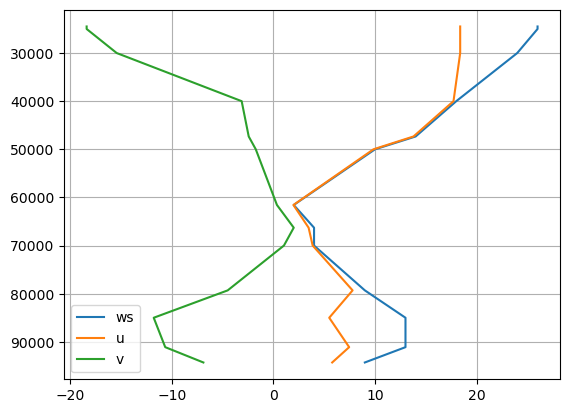

Slope ws:  -2160.0426326838824
Slope u:  -2101.5504292605165
Slope v:  2918.8720557862976


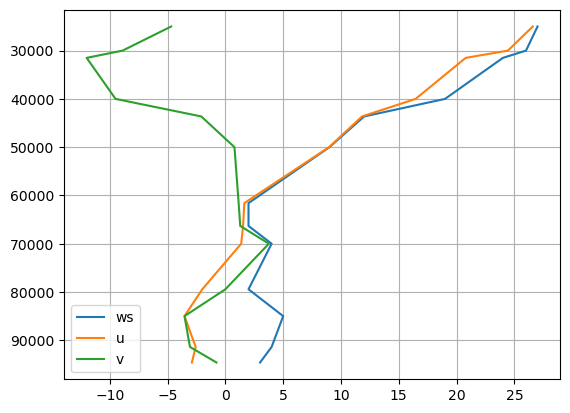

Slope ws:  -2199.6422645928533
Slope u:  -1936.5440008637815
Slope v:  2398.4108480770415


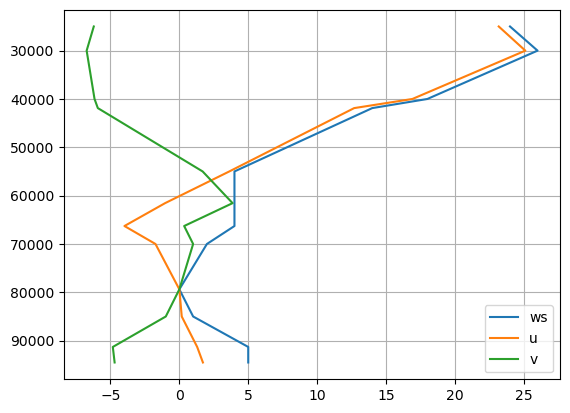

Slope ws:  -2203.9210540748327
Slope u:  -1744.368256055677
Slope v:  122.85757075171355


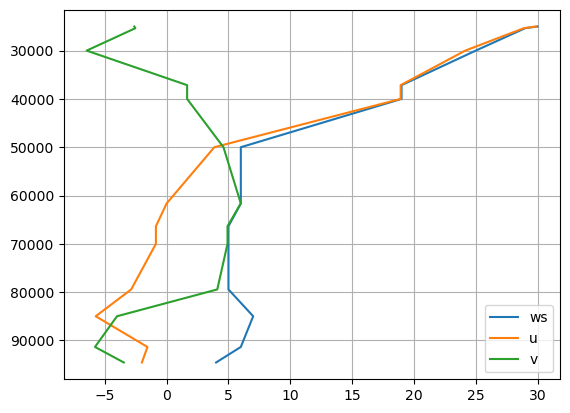

Slope ws:  -1865.1432478590393
Slope u:  -1748.2842661968432
Slope v:  2445.0563808682746


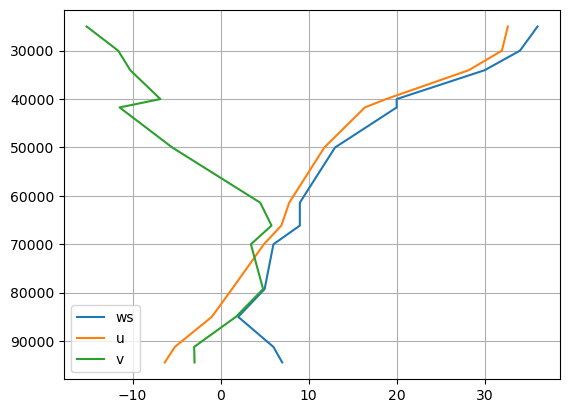

Slope ws:  -1869.2615686928348
Slope u:  -1603.2282038406188
Slope v:  2689.3870592265466


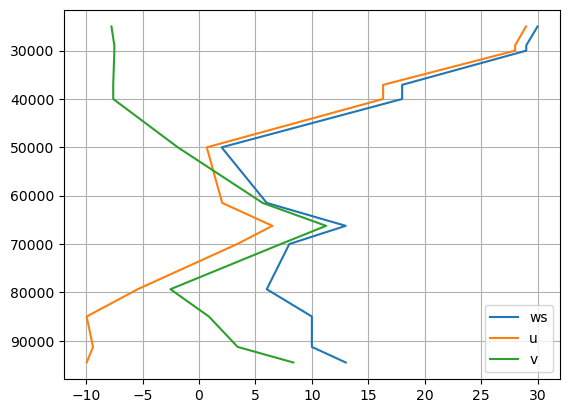

Slope ws:  -1425.9996866098359
Slope u:  -1310.1549446644563
Slope v:  3710.547297719819


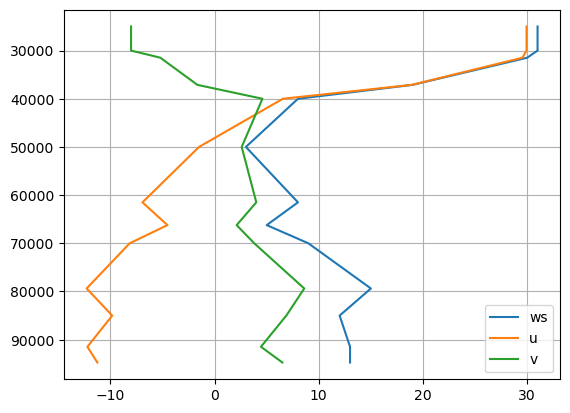

Slope ws:  -1218.1929920102789
Slope u:  -1329.9061347777297
Slope v:  7000.32914153959


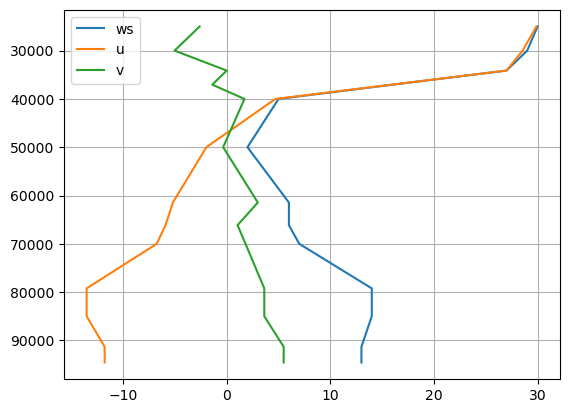

Slope ws:  -1532.1746876397583
Slope u:  -1895.5597883473288
Slope v:  1597.7553073761574


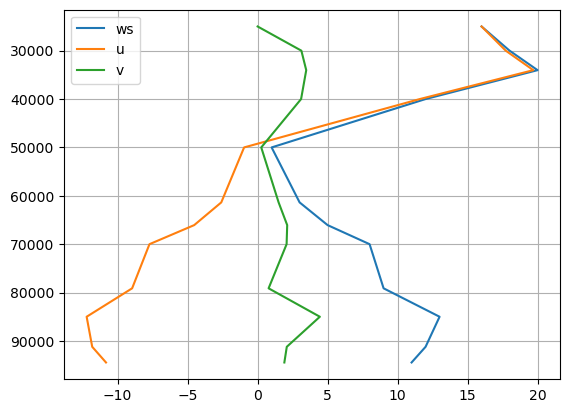

Slope ws:  -1741.50746995535
Slope u:  -1362.113966925139
Slope v:  2295.7761768612822


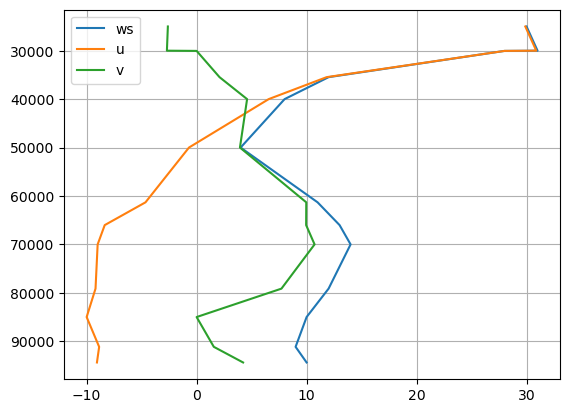

Slope ws:  -2253.707775086317
Slope u:  -1573.7097884393556
Slope v:  1093.329581492059


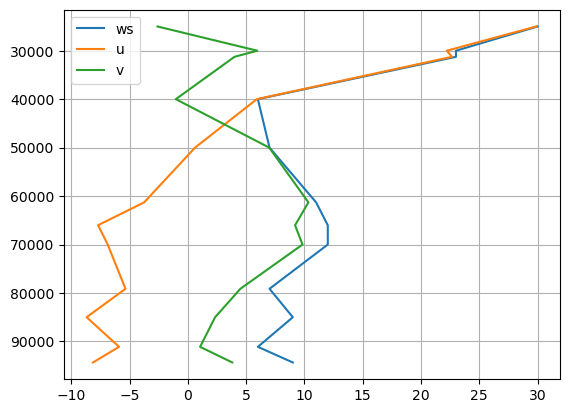

Slope ws:  -3769.036848879515
Slope u:  -5238.683522974765
Slope v:  -3091.5386199125705


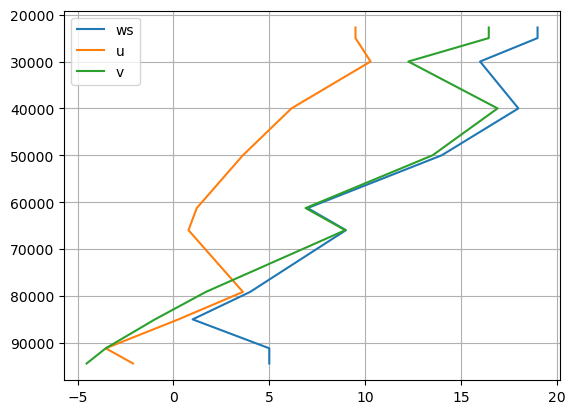

Slope ws:  -2766.0714844999798
Slope u:  -2201.582326064601
Slope v:  985.0695470995186


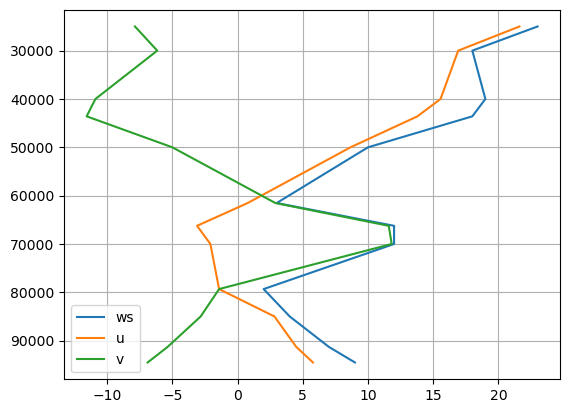

Slope ws:  -628.1292417868589
Slope u:  -2988.442426110964
Slope v:  -4151.658762833639


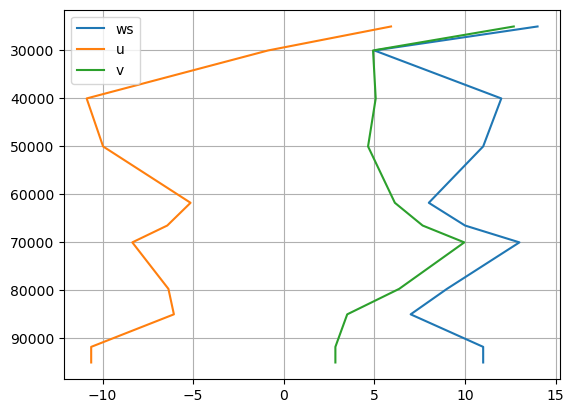

Slope ws:  -249.94741200911204
Slope u:  -2930.962261540963
Slope v:  -1225.5469041494227


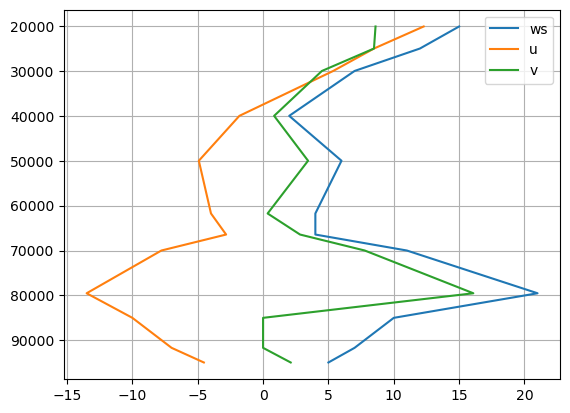

Slope ws:  -226.28565007090796
Slope u:  -798.3973879558592
Slope v:  -5754.65497675579


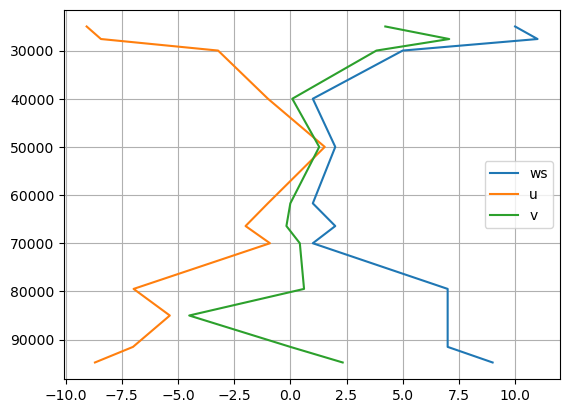

Slope ws:  -1419.2557942708333
Slope u:  -4231.102538911119
Slope v:  -2295.9403973288913


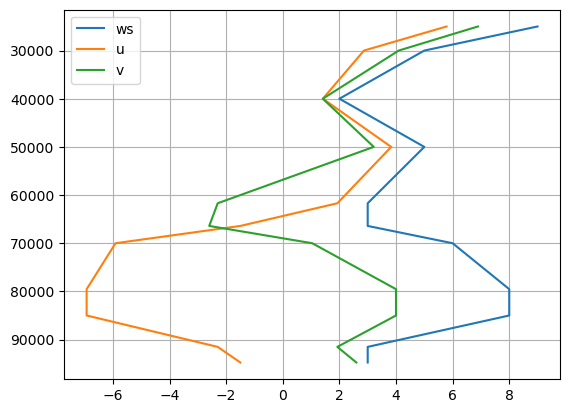

/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94380_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 39, 106, 107, 117, 126, 137, 138, 139,
       140],
      dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140, 'u_fg', 'v_fg'], dtype='object', name='observed_variable')
lat:  -23.850000381469727  lon:  151.27000427246094


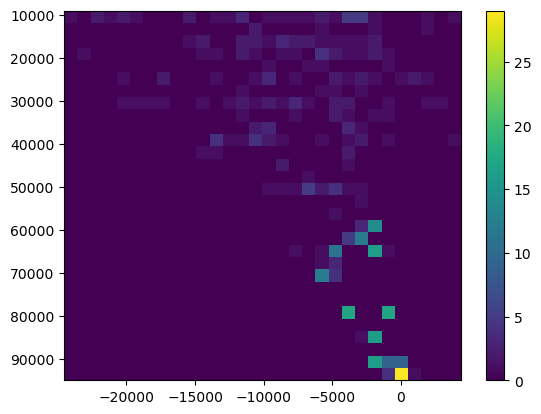

Found ascents where both (pilot and rs) are available:  17


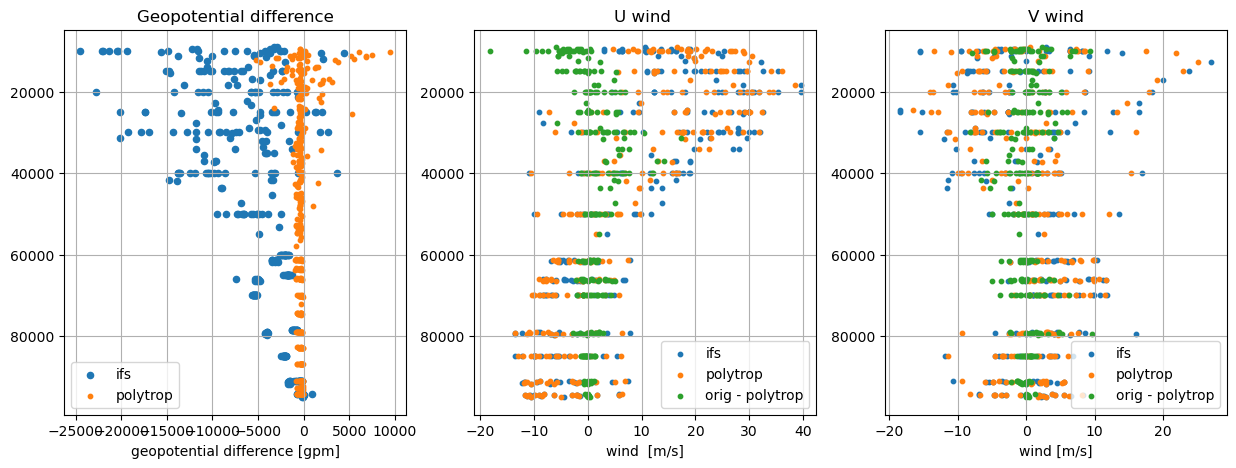

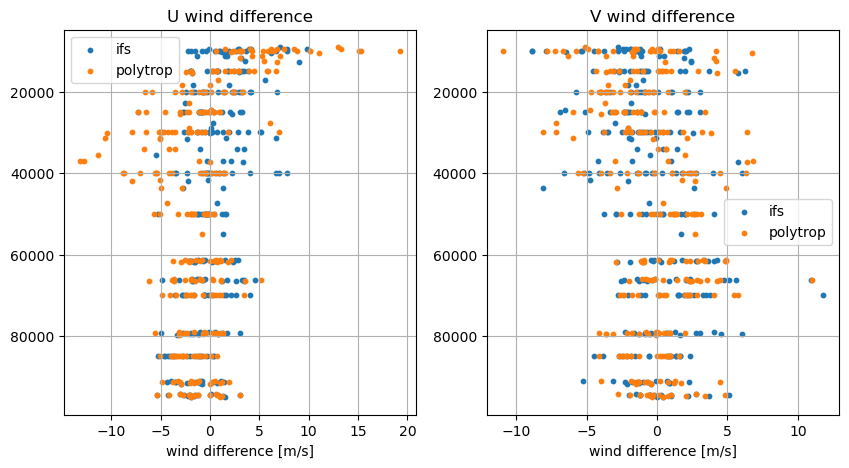

GP:  -4935.183348128745 5048.290361874861 8259.227253810404
GP poly:  -256.3997745595372 699.4869311443043 1048.93862007694
V:  -0.31167221501253656 2.221155279788418 2.472108101168423
V poly:  -0.31731072858300446 2.2582827137398733 2.673944969913689
U:  0.19644919404948968 2.1220419568860014 2.3950760698487574
U poly:  -0.5561329247937672 3.106868302565877 4.196187156361884



/srvfs/home/uvoggenberger/micromamba/envs/uv12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94212_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140], dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140, 'u_fg', 'v_fg'], dtype='object', name='observed_variable')
lat:  -18.219999313354492  lon:  127.6500015258789
No matching ascents found.

Slope ws:  -2869.164023350501
Slope u:  -2864.0045740102632
Slope v:  -283.6039394820033


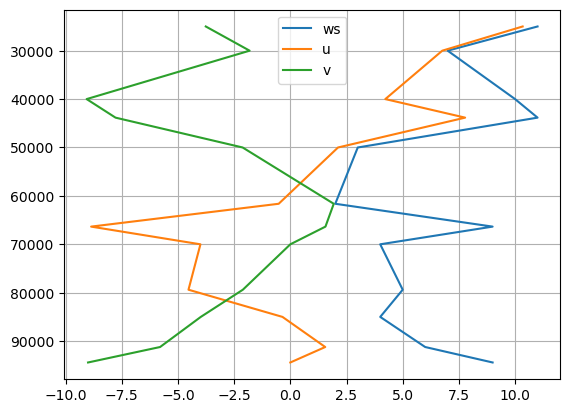

Slope ws:  -3926.233261939556
Slope u:  -2808.6137978379347
Slope v:  845.2031434486852


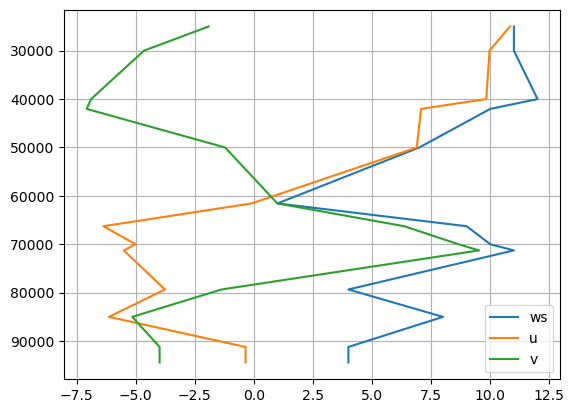

Slope ws:  -3781.3236932556297
Slope u:  -2345.1900983316095
Slope v:  648.3839262679676


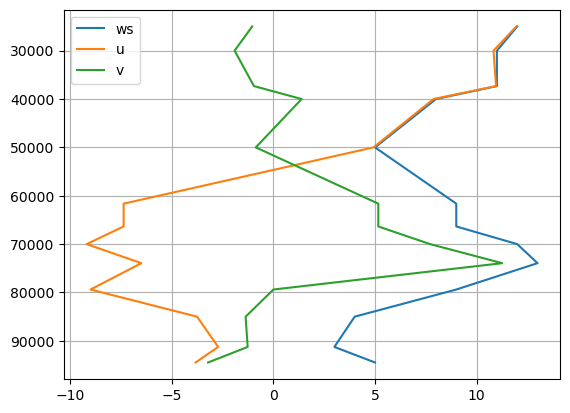

Slope ws:  -2618.470314782553
Slope u:  -2101.3982773566736
Slope v:  2394.2324401497062


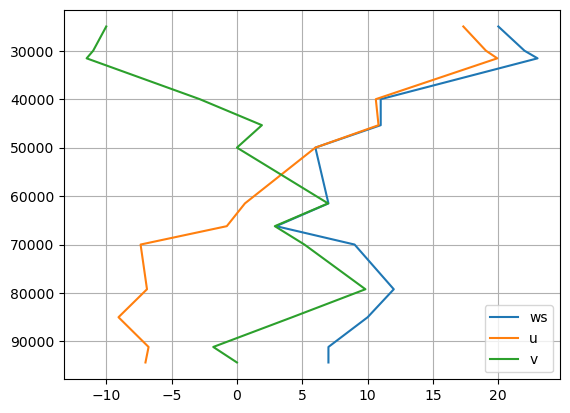

Slope ws:  -1912.3000000938325
Slope u:  -1518.7751502944539
Slope v:  999.7926398616665


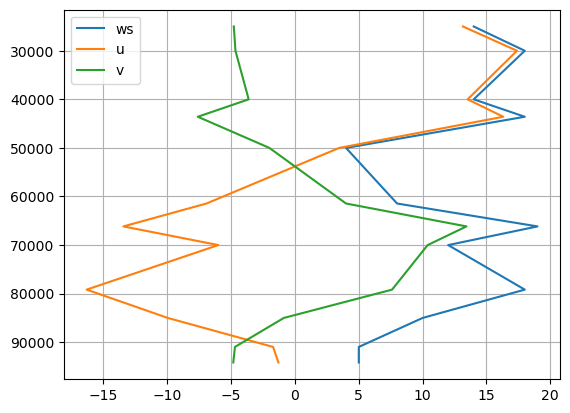

Slope ws:  -3737.6439380976217
Slope u:  -2197.0726043545387
Slope v:  3111.991897408252


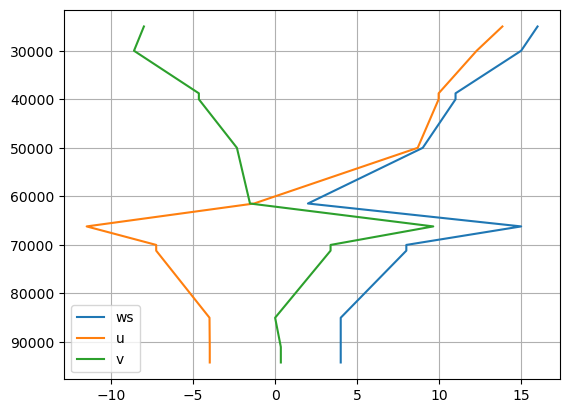

Slope ws:  -2033.764599674269
Slope u:  -2446.5123666113063
Slope v:  4679.253935058979


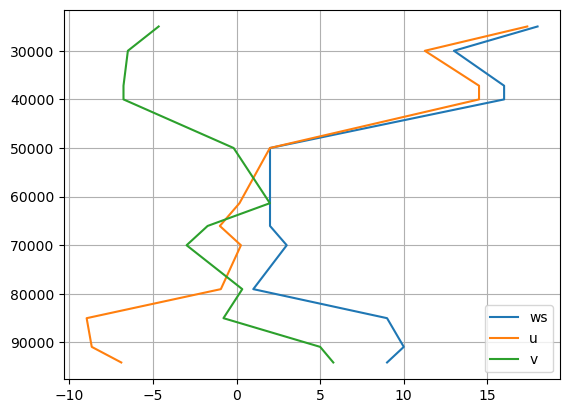

Slope ws:  6150.256331851577
Slope u:  -2774.4866324269346
Slope v:  2932.5652881690057


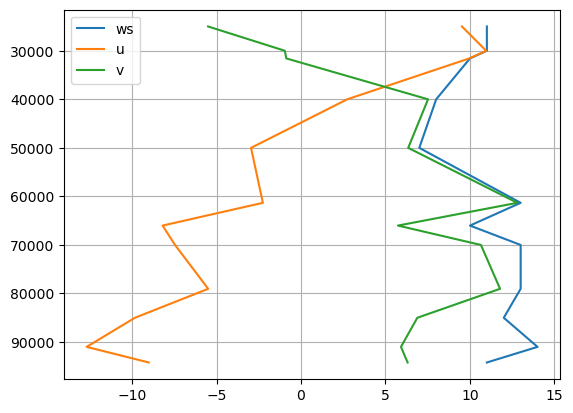

Slope ws:  -3667.426148557847
Slope u:  -756.5475031596438
Slope v:  -2045.041043238224


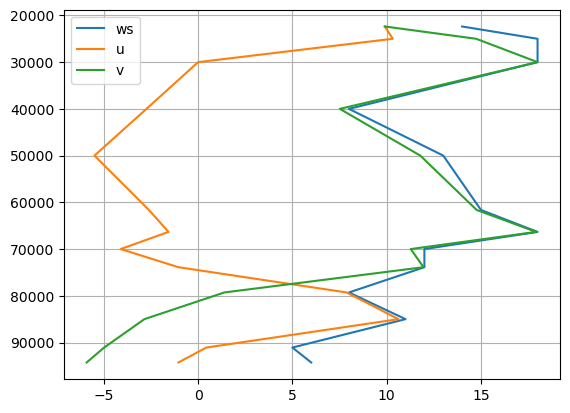

Slope ws:  -4293.178575665285
Slope u:  -4300.475655951753
Slope v:  -2250.722134296037


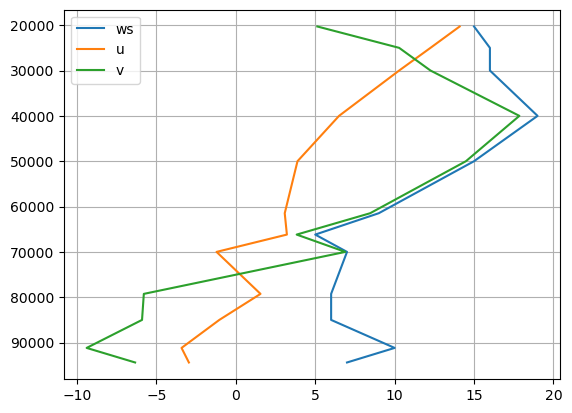

Slope ws:  4720.101395133154
Slope u:  -4906.222172167269
Slope v:  -2573.5016897824844


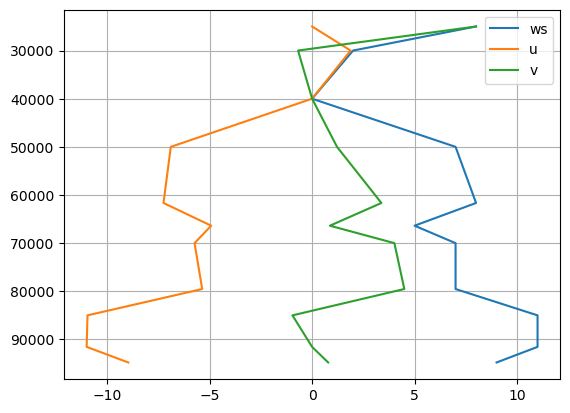

Slope ws:  2117.603930504494
Slope u:  -2289.812976066267
Slope v:  -2461.2407007122056


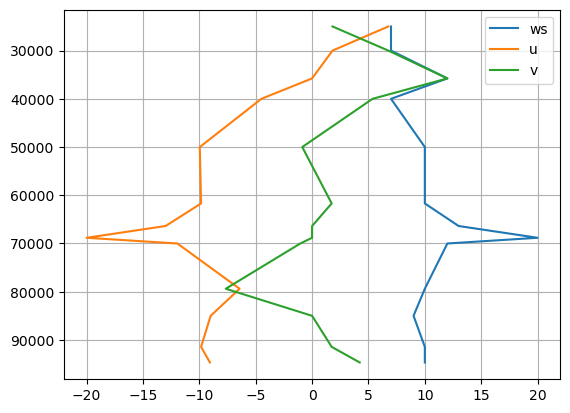

Slope ws:  -1427.650596875
Slope u:  -3115.0139102092744
Slope v:  -3384.2728220007843


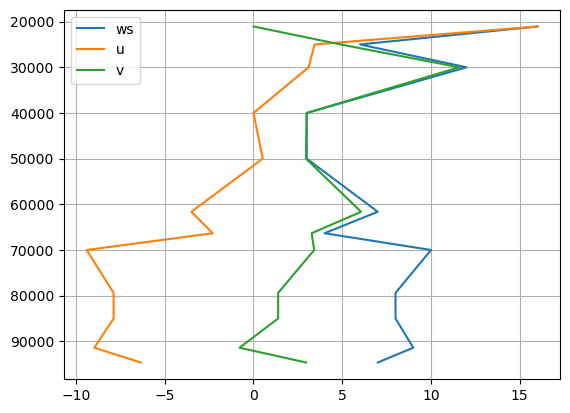

Slope ws:  2247.8355172677266
Slope u:  -3249.2421837134084
Slope v:  1767.348268769157


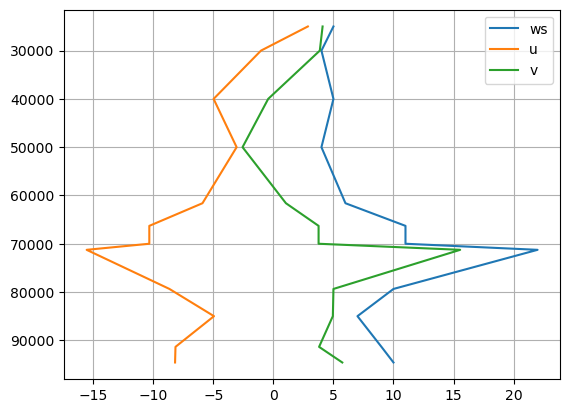

/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94294_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 39, 106, 107, 117, 126, 137, 138, 139,
       140],
      dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140, 'u_fg', 'v_fg'], dtype='object', name='observed_variable')
lat:  -19.25  lon:  146.75


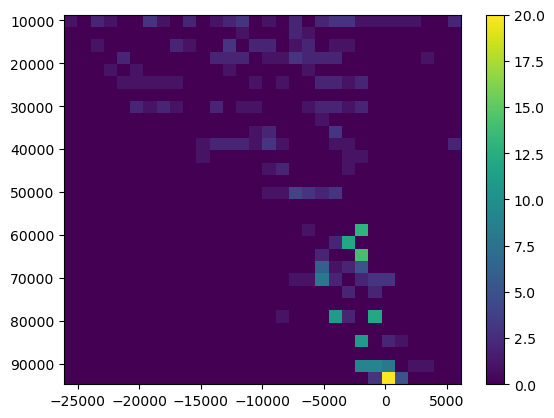

Found ascents where both (pilot and rs) are available:  14


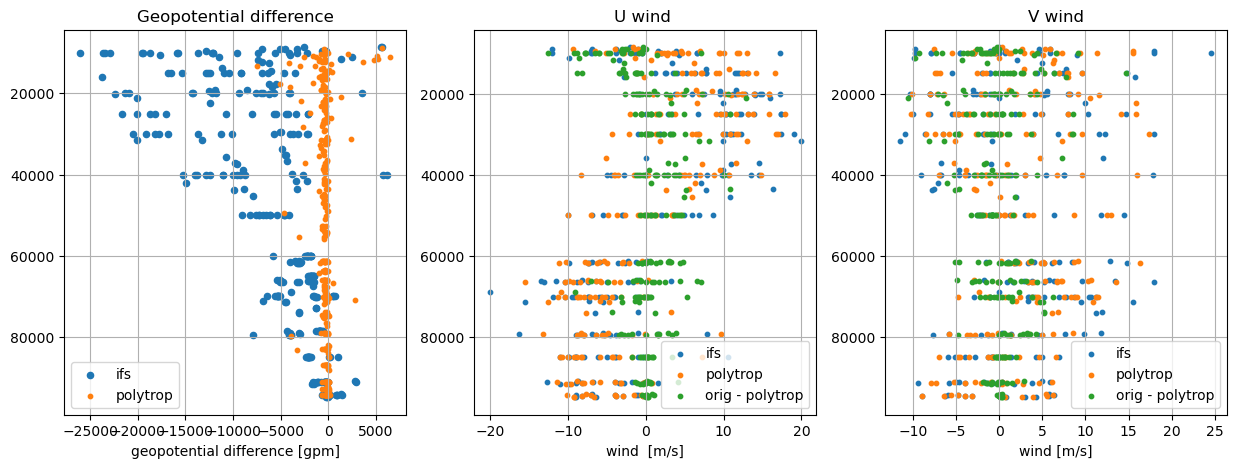

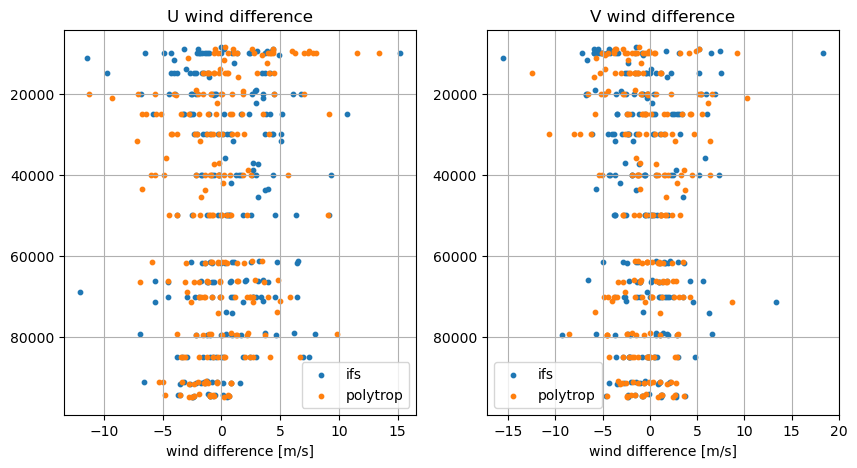

GP:  -5350.290337757656 5619.248336336283 10032.624629352795
GP poly:  -331.84426674464174 583.8525204089079 926.1768778916771
V:  -0.4777265763359851 2.716209297742823 3.307544450137926
V poly:  -0.41466861785864334 2.462410886998665 2.9777515157156
U:  0.28405985184784593 2.681032753710089 2.950508913527364
U poly:  0.010957699385550046 2.5606707334443217 3.008973547663077



/srvfs/home/uvoggenberger/micromamba/envs/uv12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94346_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140], dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140, 'u_fg', 'v_fg'], dtype='object', name='observed_variable')
lat:  -23.43722152709961  lon:  144.27694702148438
No matching ascents found.

/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94238_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140], dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140, 'u_fg', 'v_fg'], dtype='object', name='observed_variable')
lat:  -19.6299991607666  lon:  134.1699981689453
No matching ascents found.



In [8]:
## With gradient limit

g = 9.80665

for cfile in file_list[:10]:
    cdmfile = eua.CDMDataset(cfile)
    # display(cdmfile.station_configuration.secondary_id[:])
    df = cdmfile.to_dataframe(groups = ['observations_table', 'era5fb'], variables= ['date_time', 'observation_value', 'observed_variable', 'z_coordinate', 'z_coordinate_type','latitude', 'longitude', 'sensor_id', 'observation_height_above_station_surface', 'reportype', 'fg_depar@offline', 'fg_depar@body']) # 

    rs_df = df[df.reportype == 16022]
    pilot_df = df[df.reportype == 16013]

    rs_df_piv = rs_df.pivot_table(index=["date_time", "z_coordinate"], columns="observed_variable", values="observation_value").reset_index()
    pilot_df_piv = pilot_df.pivot_table(index=["date_time", "z_coordinate"], columns="observed_variable", values="observation_value").reset_index()

    pilot_df_fg = pilot_df
    pilot_df_fg['observation_value'] = pilot_df_fg['observation_value'] - pilot_df_fg['fg_depar@body'] # body or offline
    pilot_df_piv_fg = pilot_df_fg.pivot_table(index=["date_time", "z_coordinate"], columns="observed_variable", values="observation_value").reset_index()

    fg_std = np.nanstd(pilot_df_fg[np.logical_and(pilot_df_fg.date_time == '1985-11-10 17:30:00', pilot_df_fg.observed_variable == 139)]['fg_depar@body'])


    pilot_df_piv['u_fg'] = pilot_df_piv_fg[139]
    pilot_df_piv['v_fg'] = pilot_df_piv_fg[140]
    
    # test_df = pilot_df_piv[pilot_df_piv.date_time == pilot_df_piv.date_time.iloc[0]]
    # plt.scatter(test_df[139], test_df['z_coordinate'], 10, label='obs')
    # plt.scatter(test_df['u_fg'], test_df['z_coordinate'], 10, label='fg')
    # plt.gca().invert_yaxis()
    # plt.legend()
    # plt.show()
    # plt.close()


    z_for_diff = []
    gp_diff = []
    z_for_diff_poly = []
    gp_diff_poly = []

    wind_p = []
    u_diff = []
    v_diff = []
    u_diff_poly = []
    v_diff_poly = []

    u_wofg = []
    v_wofg = []
    u_poly_wofg = []
    v_poly_wofg = []


    match_days = 0
    for year in [1985]:
        for month in range(1,2): ## 13 !!!!
            for day in range(1,32):
                # if match_days > 0:
                #     continue
                try:
                    # rs_day = rs_df[rs_df.date_time == str(year) + '-' + str(month) + '-' + str(day)]
                    try:
                        pilot_day_piv = pilot_df_piv[np.logical_and(pilot_df_piv.date_time >= pd.to_datetime(f"{year}-{month}-{day} 00:00:00") , (pilot_df_piv.date_time <= pd.to_datetime(f"{year}-{month}-{day} 23:59:59")))]
                    except:
                        continue
                    for i in pilot_day_piv.date_time.drop_duplicates():
                        pilot_asc_piv = pilot_day_piv[pilot_day_piv.date_time == i]
                        # print('Pilot GP: ', list(pilot_asc_piv[117]))
                        pilot_asc_piv['z_coordinate'] = np.log(pilot_asc_piv['z_coordinate'])
                        pilot_asc_piv[117] = pilot_asc_piv.sort_values("z_coordinate")[117].interpolate(method="linear")
                        pilot_asc_piv['z_coordinate'] = np.exp(pilot_asc_piv['z_coordinate'])
                        pilot_asc_piv.dropna(subset=117, inplace=True)
                        # print('Pilot GP after interp: ', list(pilot_asc_piv[117]))
                        pilot_asc = pilot_asc_piv

                        best_match = pd.merge_asof(pilot_asc, rs_df_piv, on='date_time', direction='nearest', tolerance=pd.Timedelta('12H'))
                        rs_match = rs_df_piv[rs_df_piv.date_time == best_match.date_time.iloc[0]]
                        rs_match['z_coordinate'] = np.log(rs_match['z_coordinate'])
                        rs_match[117] = rs_match.sort_values("z_coordinate")[117].interpolate(method="linear")
                        rs_match['z_coordinate'] = np.exp(rs_match['z_coordinate'])

                        pilot_asc["date_time"] = pilot_asc["date_time"].dt.strftime("%Y-%m-%d %H:%M:%S")
                        rs_match["date_time"] = rs_match["date_time"].dt.strftime("%Y-%m-%d %H:%M:%S")


                        if len(rs_match) != 0 and len(pilot_asc) != 0: # 
                            
                            grad_test_df = pilot_asc.dropna(subset=[107, 'z_coordinate'])
                            grad_test_df = grad_test_df[grad_test_df.z_coordinate >= 20000]
                            # grad = np.gradient(grad_test_df[107], grad_test_df.z_coordinate)
                            print('Slope ws: ', linregress(grad_test_df[107], grad_test_df.z_coordinate)[0])
                            print('Slope u: ', linregress(grad_test_df[139], grad_test_df.z_coordinate)[0])
                            print('Slope v: ', linregress(grad_test_df[140], grad_test_df.z_coordinate)[0])

                            plt.plot(grad_test_df[107], grad_test_df.z_coordinate, label='ws')
                            plt.plot(grad_test_df[139], grad_test_df.z_coordinate, label='u')
                            plt.plot(grad_test_df[140], grad_test_df.z_coordinate, label='v')
                            plt.gca().invert_yaxis()
                            plt.grid()
                            plt.legend()
                            plt.show()
                            plt.close()
                            
                            z_pilot = np.array(pilot_asc.z_coordinate)
                            gp_pilot = np.array(pilot_asc[117]) # np.array(pilot_asc.observation_value)
                            z_rs = np.array(rs_match.z_coordinate)
                            gp_rs = np.array(rs_match[117]) # np.array(rs_match.observation_value)

                            calc_gp_rs_to_pilot = np.interp(z_pilot, z_rs, gp_rs)
                            z_for_diff.extend(list(z_pilot))
                            gp_diff.extend(list(gp_pilot - calc_gp_rs_to_pilot))

                            pasc_reverse = pilot_asc.iloc[::-1]
                            rs_reverse = rs_match.iloc[::-1]
                            T = np.interp(np.array(pasc_reverse[117]), np.array(rs_reverse[117]), np.array(rs_reverse[126])) # np.array(rs_reverse.observation_value), np.array(rs_reverse.temperature))
                            p_ifs = [z_to_p_ifs(pi) for pi in pasc_reverse[117]]
                            p_poly = np.flip(compute_pressure_profile(T, pasc_reverse[117] / g, p_ifs[0]))

                            calc_gp_rs_to_pilot = np.interp(p_poly, z_rs, gp_rs)
                            z_for_diff_poly.extend(list(p_poly))
                            gp_diff_poly.extend(list(gp_pilot - calc_gp_rs_to_pilot))
                            pilot_asc['p_poly'] = p_poly
                            
                            pilot_asc_clear = pilot_asc.dropna()

                            wind_p.extend(list(pilot_asc_clear['z_coordinate']))

                            u_diff.extend(list(pilot_asc_clear[139] - pilot_asc_clear['u_fg']))
                            v_diff.extend(list(pilot_asc_clear[140] - pilot_asc_clear['v_fg']))

                            u_wofg.extend(list(pilot_asc_clear[139]))
                            v_wofg.extend(list(pilot_asc_clear[140]))

                            shifted_u = np.interp(pilot_asc_clear['p_poly'], pilot_asc_clear['z_coordinate'], pilot_asc_clear[139])
                            shifted_v = np.interp(pilot_asc_clear['p_poly'], pilot_asc_clear['z_coordinate'], pilot_asc_clear[140])

                            u_diff_poly.extend(list(shifted_u - pilot_asc_clear['u_fg']))
                            v_diff_poly.extend(list(shifted_v - pilot_asc_clear['v_fg']))

                            u_poly_wofg.extend(list(shifted_u))
                            v_poly_wofg.extend(list(shifted_v))
                            
                            match_days += 1

                except:
                    pass

    
    print(cfile)
    print(rs_df_piv.dropna(subset=[139, 140]).keys())
    print(pilot_df_piv.dropna(subset=[139, 140]).keys())
    print('lat: ', cdmfile.header_table.latitude[-1], ' lon: ', cdmfile.header_table.longitude[-1])
    if match_days > 0:

        mask = ~np.isnan(gp_diff)
        plt.hist2d(np.array(gp_diff)[mask], np.array(z_for_diff)[mask], bins=[30,30], cmap='viridis')
        plt.gca().invert_yaxis()
        plt.colorbar()
        plt.show()
        plt.close()

        print("Found ascents where both (pilot and rs) are available: ", match_days)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].scatter(gp_diff, z_for_diff, s=20, label="ifs")
        axes[0].scatter(gp_diff_poly, z_for_diff_poly, s=10, label="polytrop")
        axes[0].set_title('Geopotential difference')
        axes[0].set_xlabel("geopotential difference [gpm]")
        # axes[0].set_xlim(-10000, 10000)
        axes[0].grid()
        axes[0].legend()
        axes[0].invert_yaxis()

        axes[1].scatter(u_wofg, wind_p, s=10, label="ifs")
        axes[1].scatter(u_poly_wofg, wind_p, s=10, label="polytrop")
        axes[1].scatter(np.array(u_wofg) - np.array(u_poly_wofg), wind_p, s=10, label="orig - polytrop")
        axes[1].set_title('U wind ')
        axes[1].set_xlabel("wind  [m/s]")
        # axes[1].set_xlim(-10000, 10000)
        axes[1].grid()
        axes[1].legend()
        axes[1].invert_yaxis()

        axes[2].scatter(v_wofg, wind_p, s=10, label="ifs")
        axes[2].scatter(v_poly_wofg, wind_p, s=10, label="polytrop")
        axes[2].scatter(np.array(v_wofg) - np.array(v_poly_wofg), wind_p, s=10, label="orig - polytrop")
        axes[2].set_title('V wind')
        axes[2].set_xlabel("wind [m/s]")
        # axes[2].set_xlim(-10000, 10000)
        axes[2].grid()
        axes[2].legend()
        axes[2].invert_yaxis()

        plt.show()
        plt.close()

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].scatter(u_diff, wind_p, s=10, label="ifs")
        axes[0].scatter(u_diff_poly, wind_p, s=10, label="polytrop")
        axes[0].set_title('U wind difference')
        axes[0].set_xlabel("wind difference [m/s]")
        # axes[0].set_xlim(-10000, 10000)
        axes[0].grid()
        axes[0].legend()
        axes[0].invert_yaxis()

        axes[1].scatter(v_diff, wind_p, s=10, label="ifs")
        axes[1].scatter(v_diff_poly, wind_p, s=10, label="polytrop")
        axes[1].set_title('V wind difference')
        axes[1].set_xlabel("wind difference [m/s]")
        # axes[1].set_xlim(-10000, 10000)
        axes[1].grid()
        axes[1].legend()
        axes[1].invert_yaxis()

        plt.show()
        plt.close()
        print('GP: ', np.nanmean(gp_diff), np.nanmean(np.abs(gp_diff)), np.nanmean(np.abs(np.array(gp_diff)[np.array(z_for_diff) < 50000])))
        print('GP poly: ', np.nanmean(gp_diff_poly), np.nanmean(np.abs(gp_diff_poly)), np.nanmean(np.abs(np.array(gp_diff_poly)[np.array(z_for_diff_poly) < 50000])))
        print('V: ', np.nanmean(v_diff), np.mean(np.abs(v_diff)), np.mean(np.abs(np.array(v_diff)[np.array(wind_p) < 50000])))
        print('V poly: ', np.nanmean(v_diff_poly), np.mean(np.abs(v_diff_poly)), np.mean(np.abs(np.array(v_diff_poly)[np.array(wind_p) < 50000])))
        print('U: ', np.nanmean(u_diff), np.mean(np.abs(u_diff)), np.mean(np.abs(np.array(u_diff)[np.array(wind_p) < 50000])))
        print('U poly: ', np.nanmean(u_diff_poly), np.mean(np.abs(u_diff_poly)), np.mean(np.abs(np.array(u_diff_poly)[np.array(wind_p) < 50000])))


    else:
        print('No matching ascents found.')
    print()

    # break




/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94150_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 39, 106, 107, 117, 126, 137, 138, 139,
       140],
      dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140], dtype='object', name='observed_variable')
lat:  -12.279999732971191  lon:  136.82000732421875
Found ascents where both (pilot and rs) are available:  36


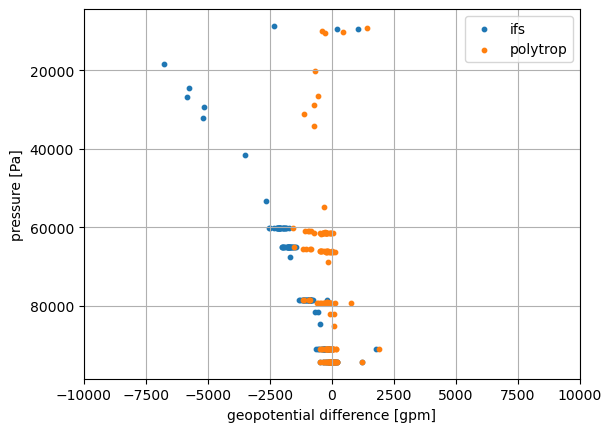

In [8]:
g = 9.80665

for cfile in file_list:
    cdmfile = eua.CDMDataset(cfile)
    # display(cdmfile.station_configuration.secondary_id[:])
    df = cdmfile.to_dataframe(groups = ['observations_table', 'era5fb'], variables= ['date_time', 'observation_value', 'observed_variable', 'z_coordinate', 'z_coordinate_type','latitude', 'longitude', 'sensor_id', 'observation_height_above_station_surface', 'reportype']) # 

    rs_df = df[df.reportype == 16022]
    pilot_df = df[df.reportype == 16013]

    rs_df_piv = rs_df.pivot_table(index=["date_time", "z_coordinate"], columns="observed_variable", values="observation_value").reset_index()
    pilot_df_piv = pilot_df.pivot_table(index=["date_time", "z_coordinate"], columns="observed_variable", values="observation_value").reset_index()


    rs_df_t = rs_df[rs_df.observed_variable == 126].rename(columns={"observation_value": "temperature"})
    rs_df = rs_df[rs_df.observed_variable == 117]
    rs_df = pd.merge(rs_df, rs_df_t[['date_time', 'z_coordinate', 'temperature']], on=['date_time', 'z_coordinate'])
    pilot_df = pilot_df[pilot_df.observed_variable == 117]

    z_for_diff = []
    gp_diff = []
    z_for_diff_poly = []
    gp_diff_poly = []

    u_diff = []
    v_diff = []
    u_diff_poly = []
    v_diff_poly = []


    match_days = 0
    for year in [1985]:
        for month in range(1,13):
            for day in range(1,32):
                try:
                    # rs_day = rs_df[rs_df.date_time == str(year) + '-' + str(month) + '-' + str(day)]
                    pilot_day = pilot_df[np.logical_and(pilot_df.date_time >= pd.to_datetime(f"{year}-{month}-{day} 00:00:00") , (pilot_df.date_time <= pd.to_datetime(f"{year}-{month}-{day} 23:59:59")))]
                    pilot_day_piv = pilot_df_piv[np.logical_and(pilot_df_piv.date_time >= pd.to_datetime(f"{year}-{month}-{day} 00:00:00") , (pilot_df_piv.date_time <= pd.to_datetime(f"{year}-{month}-{day} 23:59:59")))]
                    for i in pilot_day.date_time.drop_duplicates():
                        pilot_asc = pilot_day[pilot_day.date_time == i]

                        pilot_asc_piv = pilot_day_piv[pilot_day_piv.date_time == i]
                        # pilot_asc_piv[117] = pilot_asc_piv.sort_values("z_coordinate")[117].interpolate(method="linear")
                        pilot_asc_piv.dropna(subset=117, inplace=True)
                        pilot_asc = pilot_asc_piv

                        best_match = pd.merge_asof(pilot_asc, rs_df_piv, on='date_time', direction='nearest', tolerance=pd.Timedelta('12H'))
                        rs_match = rs_df_piv[rs_df_piv.date_time == best_match.date_time.iloc[0]]
                        pilot_asc["date_time"] = pilot_asc["date_time"].dt.strftime("%Y-%m-%d %H:%M:%S")
                        rs_match["date_time"] = rs_match["date_time"].dt.strftime("%Y-%m-%d %H:%M:%S")

                        # best_match = pd.merge_asof(pilot_asc, rs_df, on='date_time', direction='nearest', tolerance=pd.Timedelta('12H'))
                        # rs_match = rs_df[rs_df.date_time == best_match.date_time.iloc[0]]
                        # pilot_asc["date_time"] = pilot_asc["date_time"].dt.strftime("%Y-%m-%d %H:%M:%S")
                        # rs_match["date_time"] = rs_match["date_time"].dt.strftime("%Y-%m-%d %H:%M:%S")

                        if len(rs_match) != 0 and len(pilot_asc) != 0:
                            z_pilot = np.array(pilot_asc.z_coordinate)
                            gp_pilot = np.array(pilot_asc[117]) # np.array(pilot_asc.observation_value)
                            z_rs = np.array(rs_match.z_coordinate)
                            gp_rs = np.array(rs_match[117]) # np.array(rs_match.observation_value)

                            calc_gp_rs_to_pilot = np.interp(z_pilot, z_rs, gp_rs)
                            z_for_diff.extend(list(z_pilot))
                            gp_diff.extend(list(gp_pilot - calc_gp_rs_to_pilot))

                            pasc_reverse = pilot_asc.iloc[::-1]
                            rs_reverse = rs_match.iloc[::-1]
                            T = np.interp(np.array(pasc_reverse[117]), np.array(rs_reverse[117]), np.array(rs_reverse[126])) # np.array(rs_reverse.observation_value), np.array(rs_reverse.temperature))
                            p_ifs = [z_to_p_ifs(pi) for pi in pasc_reverse[117]]
                            p_poly = np.flip(compute_pressure_profile(T, pasc_reverse[117] / g, p_ifs[0]))

                            calc_gp_rs_to_pilot = np.interp(p_poly, z_rs, gp_rs)
                            z_for_diff_poly.extend(list(p_poly))
                            gp_diff_poly.extend(list(gp_pilot - calc_gp_rs_to_pilot))
                            match_days += 1


                except:
                    pass

    
    print(cfile)
    print(rs_df_piv.dropna(subset=[139, 140]).keys())
    print(pilot_df_piv.dropna(subset=[139, 140]).keys())
    print('lat: ', cdmfile.header_table.latitude[-1], ' lon: ', cdmfile.header_table.longitude[-1])
    if match_days > 0:
        print("Found ascents where both (pilot and rs) are available: ", match_days)
        plt.scatter(gp_diff, z_for_diff, 10, label = 'ifs')
        plt.scatter(gp_diff_poly, z_for_diff_poly, 10, label = 'polytrop')
        plt.ylabel("pressure [Pa]")
        plt.xlabel("geopotential difference [gpm]")
        plt.xlim(-10000, 10000)
        plt.grid()
        plt.legend()
        plt.gca().invert_yaxis()
        plt.show()
        plt.close()
    else:
        print('No matching ascents found.')
    print()
    break



In [6]:
pilot_df_piv

observed_variable,date_time,z_coordinate,106,107,117,139,140
0,1985-11-10 17:30:00,16791.828125,NaN,NaN,126510.0,NaN,NaN
1,1985-11-10 17:30:00,18520.001953,230.0,13.0,NaN,9.958578,8.356239
2,1985-11-10 17:30:00,20000.000000,30.0,13.0,NaN,-6.500000,-11.258330
3,1985-11-10 17:30:00,25000.000000,30.0,11.0,NaN,-5.500000,-9.526279
4,1985-11-10 17:30:00,25659.437500,NaN,NaN,100030.0,NaN,NaN
...,...,...,...,...,...,...,...
3053,1985-12-31 11:30:00,85000.000000,95.0,3.0,NaN,-2.988584,0.261467
3054,1985-12-31 11:30:00,90972.125000,NaN,NaN,8830.0,NaN,NaN
3055,1985-12-31 11:30:00,90995.101562,105.0,2.0,NaN,-1.931852,0.517638
3056,1985-12-31 11:30:00,94181.140625,85.0,3.0,NaN,-2.988584,-0.261467


/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94150_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 39, 106, 107, 117, 126, 137, 138, 139,
       140],
      dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140, 'u_fg', 'v_fg'], dtype='object', name='observed_variable')
lat:  -12.279999732971191  lon:  136.82000732421875


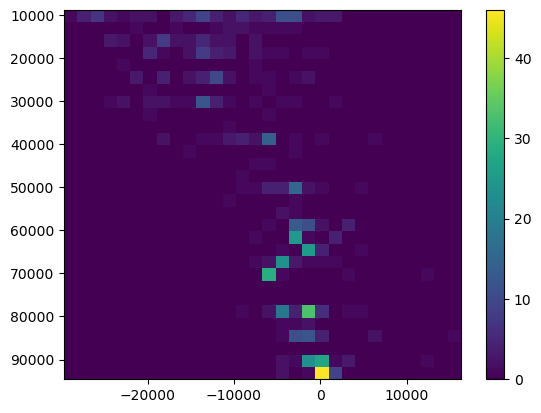

Found ascents where both (pilot and rs) are available:  35


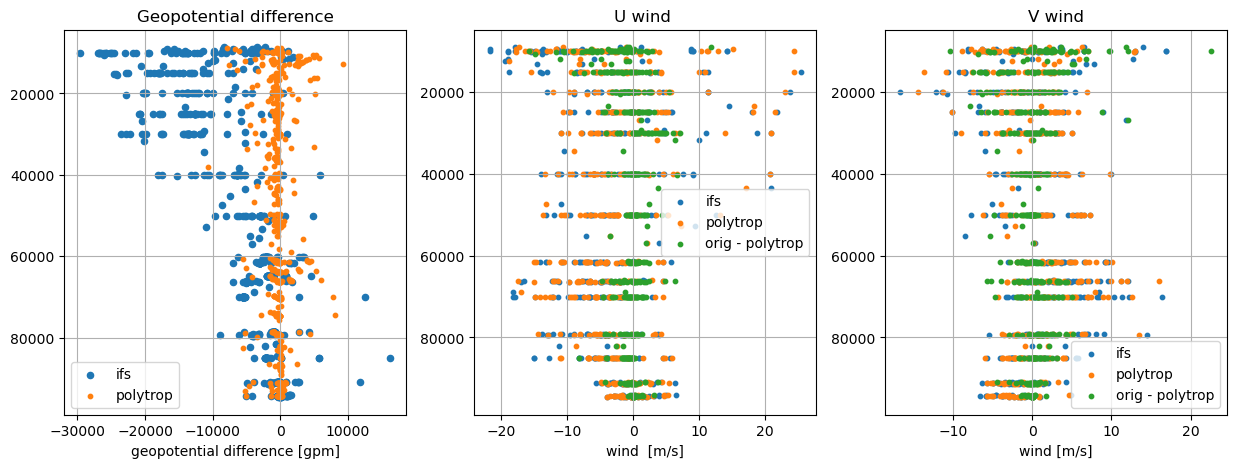

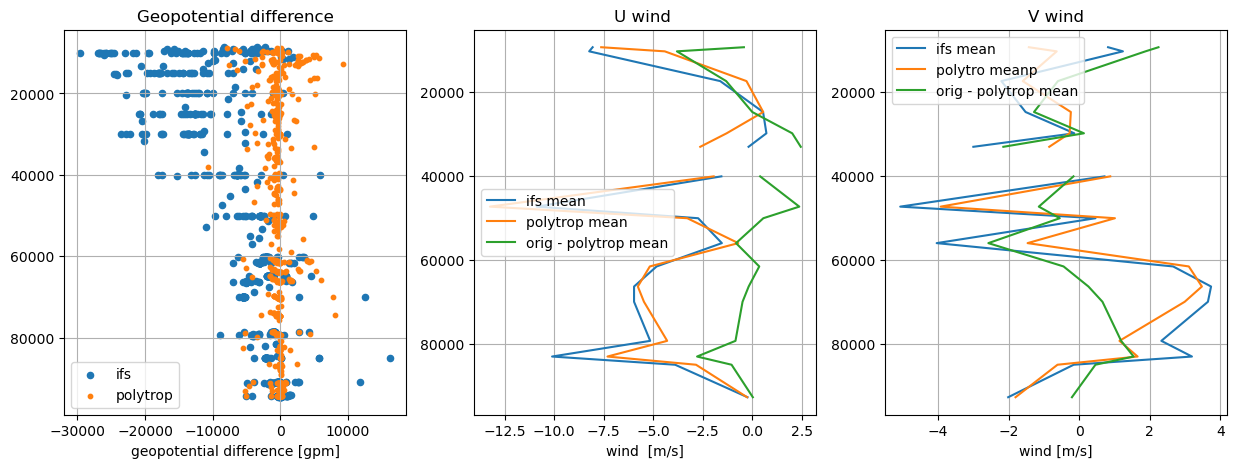

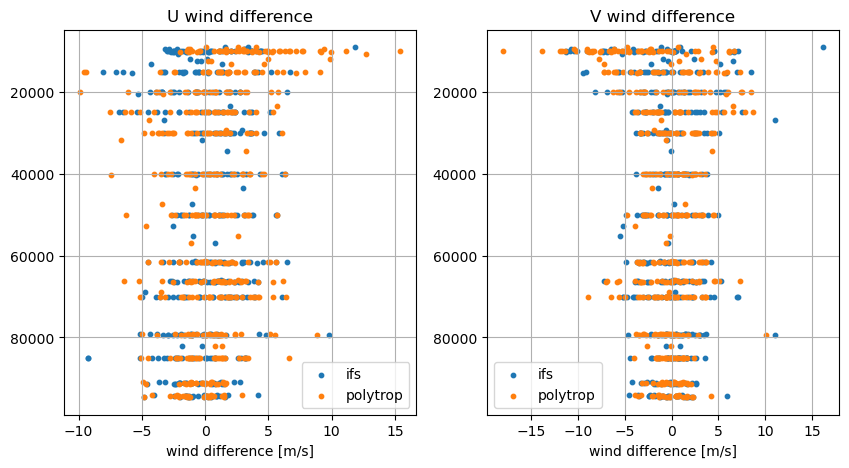

GP:  -5775.473040809813 6189.605553722688 12103.86319141089
GP poly:  -255.3626980337777 887.0695916482151 1322.519177104303
V:  -0.40250444407361785 2.322203333162924 2.909309663161
V poly:  -0.5599833988752211 2.54153563733811 3.4808178713752014
U:  0.13544437899568762 2.0771816721539094 2.2759977731659515
U poly:  0.697734854104004 2.38721006135459 3.0486846254330193



/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94174_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140], dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140, 'u_fg', 'v_fg'], dtype='object', name='observed_variable')
lat:  -10.579999923706055  lon:  142.22000122070312
No matching ascents found.

/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94287_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140], dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140, 'u_fg', 'v_fg'], dtype='object', name='observed_variable')
lat:  -16.8799991607666  lon:  145.75
No matching ascents found.

/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94367_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140], dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 1

/srvfs/home/uvoggenberger/micromamba/envs/uv12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94476_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140], dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140, 'u_fg', 'v_fg'], dtype='object', name='observed_variable')
lat:  -27.549999237060547  lon:  135.42999267578125
No matching ascents found.

/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94380_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 39, 106, 107, 117, 126, 137, 138, 139,
       140],
      dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140, 'u_fg', 'v_fg'], dtype='object', name='observed_variable')
lat:  -23.850000381469727  lon:  151.27000427246094


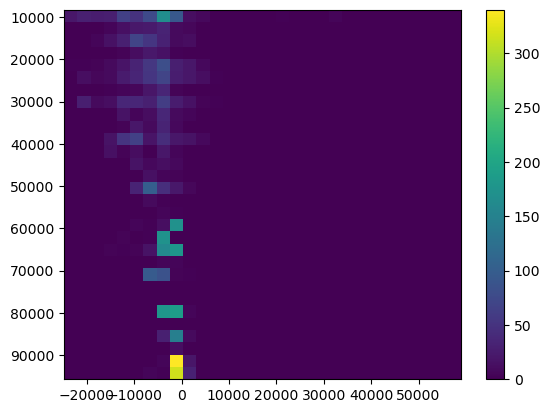

Found ascents where both (pilot and rs) are available:  185


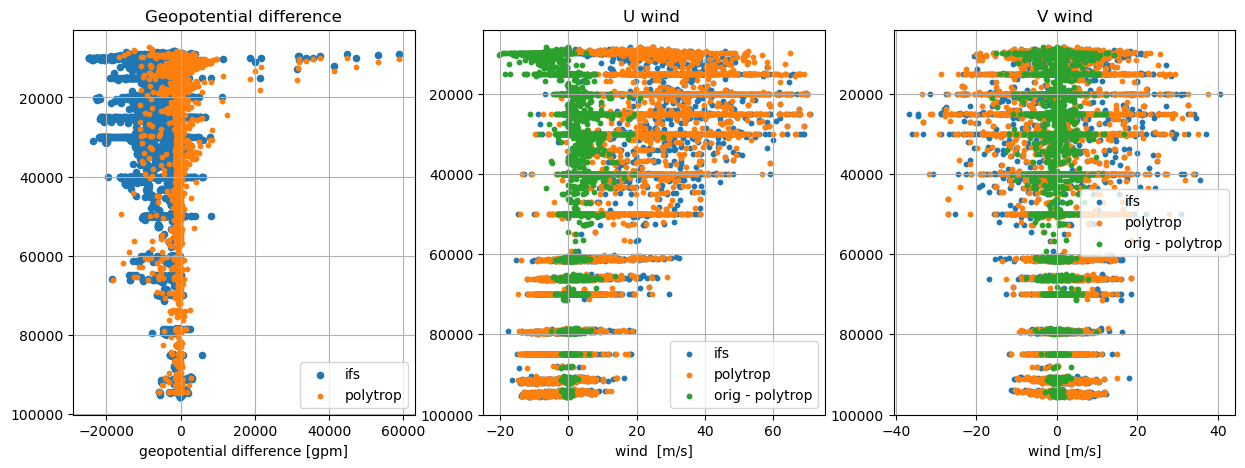

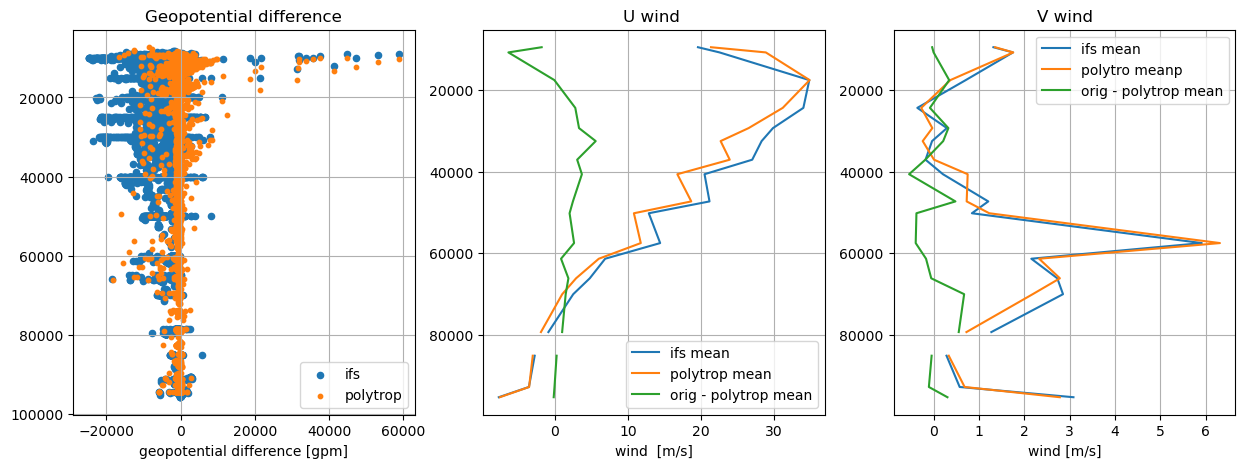

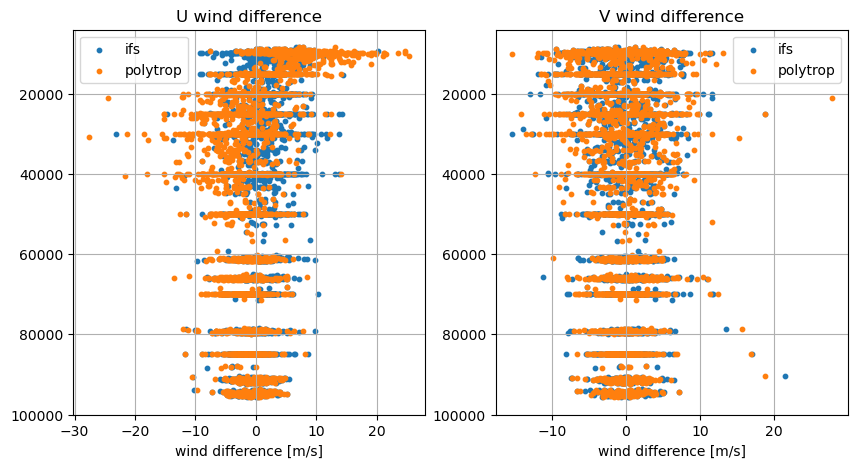

GP:  -4605.554194670468 5057.643903344321 7552.149110777962
GP poly:  -505.1690104170455 1096.164993403067 1515.7445591343342
V:  -0.07705306125029644 2.440633384668216 2.8393950458897943
V poly:  -0.1212882320321838 2.5424214067510262 3.112199951396842
U:  0.5363961797924885 2.5415185302357126 2.9603181014268953
U poly:  -0.14437394147415863 3.5951850230619558 4.721731741261257



/srvfs/home/uvoggenberger/micromamba/envs/uv12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94212_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140], dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140, 'u_fg', 'v_fg'], dtype='object', name='observed_variable')
lat:  -18.219999313354492  lon:  127.6500015258789
No matching ascents found.

/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94294_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 39, 106, 107, 117, 126, 137, 138, 139,
       140],
      dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140, 'u_fg', 'v_fg'], dtype='object', name='observed_variable')
lat:  -19.25  lon:  146.75


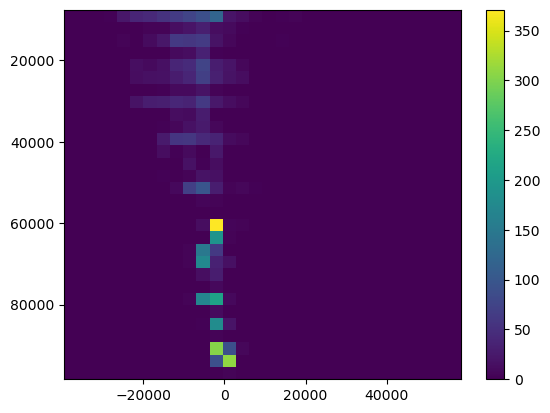

Found ascents where both (pilot and rs) are available:  203


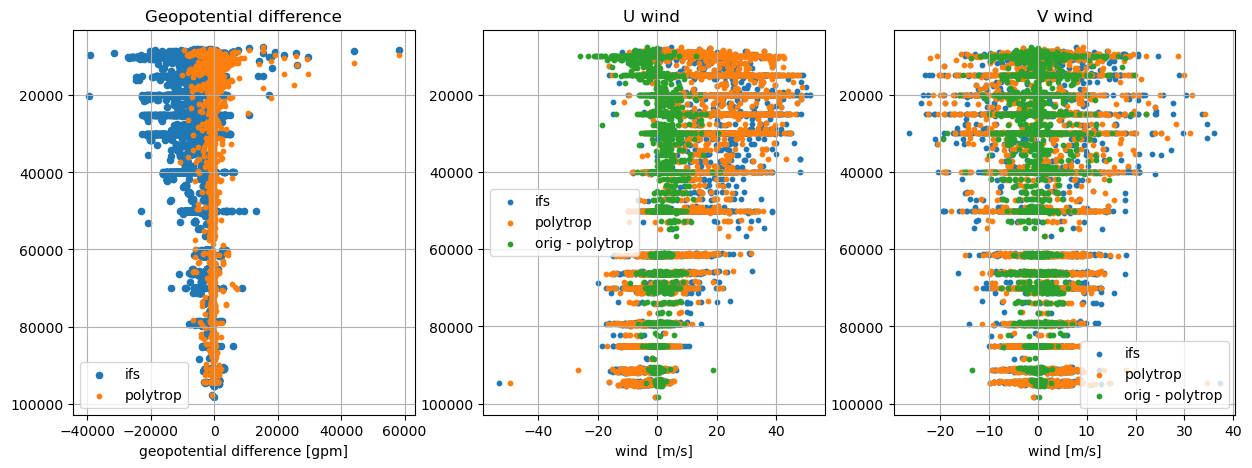

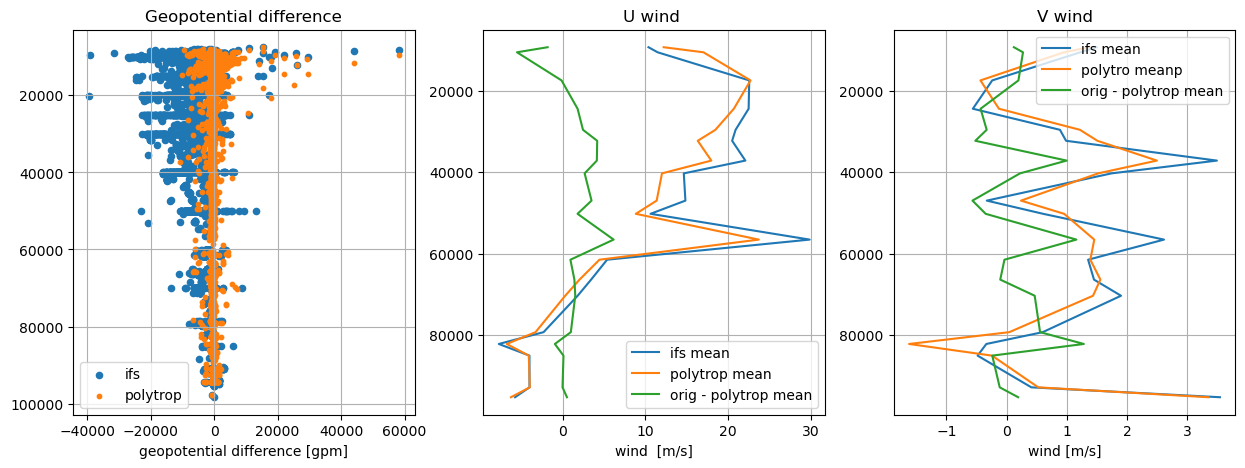

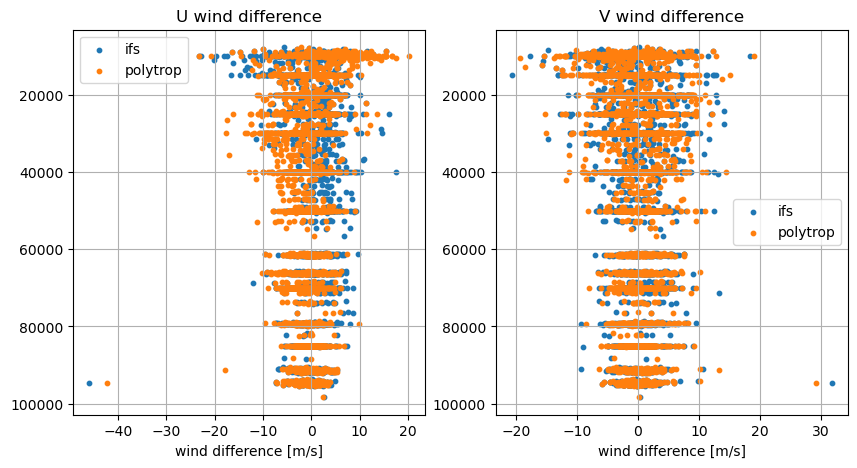

GP:  -4933.006519550563 5314.5726661204635 8746.230364542937
GP poly:  -369.58862423324814 893.7833633659831 1328.5165938913829
V:  -0.04654362408695874 2.6037738253425236 3.186134440265707
V poly:  -0.06934354162192974 2.631405057787728 3.328494319318256
U:  0.14580549895551417 2.6259964245747227 3.144083999332816
U poly:  -0.323461436666119 2.962384385247917 3.77794606798413



/srvfs/home/uvoggenberger/micromamba/envs/uv12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94346_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140], dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140, 'u_fg', 'v_fg'], dtype='object', name='observed_variable')
lat:  -23.43722152709961  lon:  144.27694702148438
No matching ascents found.

/mnt/users/scratch/leo/scratch/converted_v29/1985/0-20000-0-94238_CEUAS_merged_v3.nc
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140], dtype='object', name='observed_variable')
Index(['date_time', 'z_coordinate', 106, 107, 117, 139, 140, 'u_fg', 'v_fg'], dtype='object', name='observed_variable')
lat:  -19.6299991607666  lon:  134.1699981689453
No matching ascents found.



In [10]:
g = 9.80665

for cfile in file_list[:10]:
    cdmfile = eua.CDMDataset(cfile)
    # display(cdmfile.station_configuration.secondary_id[:])
    df = cdmfile.to_dataframe(groups = ['observations_table', 'era5fb'], variables= ['date_time', 'observation_value', 'observed_variable', 'z_coordinate', 'z_coordinate_type','latitude', 'longitude', 'sensor_id', 'observation_height_above_station_surface', 'reportype', 'fg_depar@offline', 'fg_depar@body']) # 

    rs_df = df[df.reportype == 16022]
    pilot_df = df[df.reportype == 16013]

    rs_df_piv = rs_df.pivot_table(index=["date_time", "z_coordinate"], columns="observed_variable", values="observation_value").reset_index()
    pilot_df_piv = pilot_df.pivot_table(index=["date_time", "z_coordinate"], columns="observed_variable", values="observation_value").reset_index()

    pilot_df_fg = pilot_df
    pilot_df_fg['observation_value'] = pilot_df_fg['observation_value'] - pilot_df_fg['fg_depar@body'] # body or offline
    pilot_df_piv_fg = pilot_df_fg.pivot_table(index=["date_time", "z_coordinate"], columns="observed_variable", values="observation_value").reset_index()

    fg_std = np.nanstd(pilot_df_fg[np.logical_and(pilot_df_fg.date_time == '1985-11-10 17:30:00', pilot_df_fg.observed_variable == 139)]['fg_depar@body'])


    pilot_df_piv['u_fg'] = pilot_df_piv_fg[139]
    pilot_df_piv['v_fg'] = pilot_df_piv_fg[140]
    
    # test_df = pilot_df_piv[pilot_df_piv.date_time == pilot_df_piv.date_time.iloc[0]]
    # plt.scatter(test_df[139], test_df['z_coordinate'], 10, label='obs')
    # plt.scatter(test_df['u_fg'], test_df['z_coordinate'], 10, label='fg')
    # plt.gca().invert_yaxis()
    # plt.legend()
    # plt.show()
    # plt.close()


    z_for_diff = []
    gp_diff = []
    z_for_diff_poly = []
    gp_diff_poly = []

    wind_p = []
    u_diff = []
    v_diff = []
    u_diff_poly = []
    v_diff_poly = []

    u_wofg = []
    v_wofg = []
    u_poly_wofg = []
    v_poly_wofg = []


    match_days = 0
    for year in [1985]:
        for month in range(1,13):
            for day in range(1,32):
                # if match_days > 0:
                #     continue
                try:
                    # rs_day = rs_df[rs_df.date_time == str(year) + '-' + str(month) + '-' + str(day)]
                    try:
                        pilot_day_piv = pilot_df_piv[np.logical_and(pilot_df_piv.date_time >= pd.to_datetime(f"{year}-{month}-{day} 00:00:00") , (pilot_df_piv.date_time <= pd.to_datetime(f"{year}-{month}-{day} 23:59:59")))]
                    except:
                        continue
                    for i in pilot_day_piv.date_time.drop_duplicates():
                        pilot_asc_piv = pilot_day_piv[pilot_day_piv.date_time == i]
                        # print('Pilot GP: ', list(pilot_asc_piv[117]))
                        pilot_asc_piv['z_coordinate'] = np.log(pilot_asc_piv['z_coordinate'])
                        pilot_asc_piv[117] = pilot_asc_piv.sort_values("z_coordinate")[117].interpolate(method="linear")
                        pilot_asc_piv['z_coordinate'] = np.exp(pilot_asc_piv['z_coordinate'])
                        pilot_asc_piv.dropna(subset=117, inplace=True)
                        # print('Pilot GP after interp: ', list(pilot_asc_piv[117]))
                        pilot_asc = pilot_asc_piv

                        best_match = pd.merge_asof(pilot_asc, rs_df_piv, on='date_time', direction='nearest', tolerance=pd.Timedelta('12H'))
                        rs_match = rs_df_piv[rs_df_piv.date_time == best_match.date_time.iloc[0]]
                        rs_match['z_coordinate'] = np.log(rs_match['z_coordinate'])
                        rs_match[117] = rs_match.sort_values("z_coordinate")[117].interpolate(method="linear")
                        rs_match['z_coordinate'] = np.exp(rs_match['z_coordinate'])

                        pilot_asc["date_time"] = pilot_asc["date_time"].dt.strftime("%Y-%m-%d %H:%M:%S")
                        rs_match["date_time"] = rs_match["date_time"].dt.strftime("%Y-%m-%d %H:%M:%S")


                        if len(rs_match) != 0 and len(pilot_asc) != 0: # 
                            
                            z_pilot = np.array(pilot_asc.z_coordinate)
                            gp_pilot = np.array(pilot_asc[117]) # np.array(pilot_asc.observation_value)
                            z_rs = np.array(rs_match.z_coordinate)
                            gp_rs = np.array(rs_match[117]) # np.array(rs_match.observation_value)

                            calc_gp_rs_to_pilot = np.interp(z_pilot, z_rs, gp_rs)
                            z_for_diff.extend(list(z_pilot))
                            gp_diff.extend(list(gp_pilot - calc_gp_rs_to_pilot))

                            pasc_reverse = pilot_asc.iloc[::-1]
                            rs_reverse = rs_match.iloc[::-1]
                            T = np.interp(np.array(pasc_reverse[117]), np.array(rs_reverse[117]), np.array(rs_reverse[126])) # np.array(rs_reverse.observation_value), np.array(rs_reverse.temperature))
                            p_ifs = [z_to_p_ifs(pi) for pi in pasc_reverse[117]]
                            p_poly = np.flip(compute_pressure_profile(T, pasc_reverse[117] / g, p_ifs[0]))

                            calc_gp_rs_to_pilot = np.interp(p_poly, z_rs, gp_rs)
                            z_for_diff_poly.extend(list(p_poly))
                            gp_diff_poly.extend(list(gp_pilot - calc_gp_rs_to_pilot))
                            pilot_asc['p_poly'] = p_poly
                            
                            pilot_asc_clear = pilot_asc.dropna()

                            wind_p.extend(list(pilot_asc_clear['z_coordinate']))

                            u_diff.extend(list(pilot_asc_clear[139] - pilot_asc_clear['u_fg']))
                            v_diff.extend(list(pilot_asc_clear[140] - pilot_asc_clear['v_fg']))

                            u_wofg.extend(list(pilot_asc_clear[139]))
                            v_wofg.extend(list(pilot_asc_clear[140]))

                            shifted_u = np.interp(pilot_asc_clear['p_poly'], pilot_asc_clear['z_coordinate'], pilot_asc_clear[139])
                            shifted_v = np.interp(pilot_asc_clear['p_poly'], pilot_asc_clear['z_coordinate'], pilot_asc_clear[140])

                            u_diff_poly.extend(list(shifted_u - pilot_asc_clear['u_fg']))
                            v_diff_poly.extend(list(shifted_v - pilot_asc_clear['v_fg']))

                            u_poly_wofg.extend(list(shifted_u))
                            v_poly_wofg.extend(list(shifted_v))
                            
                            match_days += 1

                except:
                    pass

    
    print(cfile)
    print(rs_df_piv.dropna(subset=[139, 140]).keys())
    print(pilot_df_piv.dropna(subset=[139, 140]).keys())
    print('lat: ', cdmfile.header_table.latitude[-1], ' lon: ', cdmfile.header_table.longitude[-1])
    if match_days > 0:

        mask = ~np.isnan(gp_diff)
        plt.hist2d(np.array(gp_diff)[mask], np.array(z_for_diff)[mask], bins=[30,30], cmap='viridis')
        plt.gca().invert_yaxis()
        plt.colorbar()
        plt.show()
        plt.close()

        print("Found ascents where both (pilot and rs) are available: ", match_days)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].scatter(gp_diff, z_for_diff, s=20, label="ifs")
        axes[0].scatter(gp_diff_poly, z_for_diff_poly, s=10, label="polytrop")
        axes[0].set_title('Geopotential difference')
        axes[0].set_xlabel("geopotential difference [gpm]")
        # axes[0].set_xlim(-10000, 10000)
        axes[0].grid()
        axes[0].legend()
        axes[0].invert_yaxis()

        axes[1].scatter(u_wofg, wind_p, s=10, label="ifs")
        axes[1].scatter(u_poly_wofg, wind_p, s=10, label="polytrop")
        axes[1].scatter(np.array(u_wofg) - np.array(u_poly_wofg), wind_p, s=10, label="orig - polytrop")
        axes[1].set_title('U wind ')
        axes[1].set_xlabel("wind  [m/s]")
        # axes[1].set_xlim(-10000, 10000)
        axes[1].grid()
        axes[1].legend()
        axes[1].invert_yaxis()

        axes[2].scatter(v_wofg, wind_p, s=10, label="ifs")
        axes[2].scatter(v_poly_wofg, wind_p, s=10, label="polytrop")
        axes[2].scatter(np.array(v_wofg) - np.array(v_poly_wofg), wind_p, s=10, label="orig - polytrop")
        axes[2].set_title('V wind')
        axes[2].set_xlabel("wind [m/s]")
        # axes[2].set_xlim(-10000, 10000)
        axes[2].grid()
        axes[2].legend()
        axes[2].invert_yaxis()

        plt.show()
        plt.close()
        
        ###
        #
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].scatter(gp_diff, z_for_diff, s=20, label="ifs")
        axes[0].scatter(gp_diff_poly, z_for_diff_poly, s=10, label="polytrop")
        axes[0].set_title('Geopotential difference')
        axes[0].set_xlabel("geopotential difference [gpm]")
        # axes[0].set_xlim(-10000, 10000)
        axes[0].grid()
        axes[0].legend()
        axes[0].invert_yaxis()

        # Create a DataFrame from the data
        data = {'v_poly_wofg': v_poly_wofg, 'v_wofg': v_wofg, 'u_poly_wofg': u_poly_wofg, 'u_wofg': u_wofg, 'wind_p': wind_p}
        df = pd.DataFrame(data)
        # Create a new column for 10 hPa (1000 Pa) segments
        df['pressure_bin'] = pd.cut(df['wind_p'], bins=np.arange(0, max(df['wind_p']) + 5000, 5000), right=False)
        # Group by the pressure bins and calculate the mean 
        mean_u_wofg = df.groupby('pressure_bin')['u_wofg'].mean()
        mean_u_poly_wofg = df.groupby('pressure_bin')['u_poly_wofg'].mean()
        mean_v_wofg = df.groupby('pressure_bin')['v_wofg'].mean()
        mean_v_poly_wofg = df.groupby('pressure_bin')['v_poly_wofg'].mean()
        mean_wind_p = df.groupby('pressure_bin')['wind_p'].mean()

        axes[1].plot(mean_u_wofg, mean_wind_p, label="ifs mean")
        axes[1].plot(mean_u_poly_wofg, mean_wind_p, label="polytrop mean")
        axes[1].plot(np.array(mean_u_wofg) - np.array(mean_u_poly_wofg), mean_wind_p, label="orig - polytrop mean")
        axes[1].set_title('U wind ')
        axes[1].set_xlabel("wind  [m/s]")
        # axes[1].set_xlim(-10000, 10000)
        axes[1].grid()
        axes[1].legend()
        axes[1].invert_yaxis()

        axes[2].plot(mean_v_wofg, mean_wind_p, label="ifs mean")
        axes[2].plot(mean_v_poly_wofg, mean_wind_p, label="polytro meanp")
        axes[2].plot(np.array(mean_v_wofg) - np.array(mean_v_poly_wofg), mean_wind_p, label="orig - polytrop mean")
        axes[2].set_title('V wind')
        axes[2].set_xlabel("wind [m/s]")
        # axes[2].set_xlim(-10000, 10000)
        axes[2].grid()
        axes[2].legend()
        axes[2].invert_yaxis()

        plt.show()
        plt.close()
        
        #
        ###

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].scatter(u_diff, wind_p, s=10, label="ifs")
        axes[0].scatter(u_diff_poly, wind_p, s=10, label="polytrop")
        axes[0].set_title('U wind difference')
        axes[0].set_xlabel("wind difference [m/s]")
        # axes[0].set_xlim(-10000, 10000)
        axes[0].grid()
        axes[0].legend()
        axes[0].invert_yaxis()

        axes[1].scatter(v_diff, wind_p, s=10, label="ifs")
        axes[1].scatter(v_diff_poly, wind_p, s=10, label="polytrop")
        axes[1].set_title('V wind difference')
        axes[1].set_xlabel("wind difference [m/s]")
        # axes[1].set_xlim(-10000, 10000)
        axes[1].grid()
        axes[1].legend()
        axes[1].invert_yaxis()

        plt.show()
        plt.close()
        print('GP: ', np.nanmean(gp_diff), np.nanmean(np.abs(gp_diff)), np.nanmean(np.abs(np.array(gp_diff)[np.array(z_for_diff) < 50000])))
        print('GP poly: ', np.nanmean(gp_diff_poly), np.nanmean(np.abs(gp_diff_poly)), np.nanmean(np.abs(np.array(gp_diff_poly)[np.array(z_for_diff_poly) < 50000])))
        print('V: ', np.nanmean(v_diff), np.mean(np.abs(v_diff)), np.mean(np.abs(np.array(v_diff)[np.array(wind_p) < 50000])))
        print('V poly: ', np.nanmean(v_diff_poly), np.mean(np.abs(v_diff_poly)), np.mean(np.abs(np.array(v_diff_poly)[np.array(wind_p) < 50000])))
        print('U: ', np.nanmean(u_diff), np.mean(np.abs(u_diff)), np.mean(np.abs(np.array(u_diff)[np.array(wind_p) < 50000])))
        print('U poly: ', np.nanmean(u_diff_poly), np.mean(np.abs(u_diff_poly)), np.mean(np.abs(np.array(u_diff_poly)[np.array(wind_p) < 50000])))


    else:
        print('No matching ascents found.')
    print()

    # break




Calc only, where gradient is big enough.
--||-- where diff is small in the first place.


synth profile: 0-40ms 1000-200hpa


In [24]:
np.random.randn(100, )*3


array([ 1.5669247 , -1.48395947, -5.69879464, -0.06136969, -4.92173632,
        2.40398587, -1.69508811, -3.48614144, -0.2235463 ,  1.61867018,
       -4.7213936 , -1.41397268,  2.7074667 , -5.21627368,  0.45090328,
        2.82631199,  0.97901355, -3.88941655, -0.32850682, -4.15175918,
        1.3318933 , -4.00981565,  5.28644719,  0.33177748,  1.51861731,
        0.62133473,  0.32704711, -1.31431475, -3.09002714, -6.11413503,
        6.14763632,  2.19147805,  1.83110199, -0.40234242, -0.93499627,
        0.32815709, -1.28232527, -4.41307306,  1.30897007, -1.12139944,
       -0.50487562,  0.33976387, -1.3401622 ,  4.47032131,  2.37987915,
        3.34874917,  5.59495989,  1.48419973, -5.67738622,  2.66274583,
        2.93875382, -5.67298177, -1.47283433,  0.79951978,  5.07351365,
       -0.39344548,  1.45477609, -4.95530807, -5.50081485,  0.29799117,
        2.71861247, -0.30414994,  0.58621936, -0.80471589,  0.90892765,
        1.19723796, -3.02832278,  3.68899795, -0.23201544,  0.30

p:  [1000.0, 991.9191919191919, 983.8383838383838, 975.7575757575758, 967.6767676767677, 959.5959595959596, 951.5151515151515, 943.4343434343434, 935.3535353535353, 927.2727272727273, 919.1919191919192, 911.1111111111111, 903.030303030303, 894.9494949494949, 886.8686868686868, 878.7878787878788, 870.7070707070707, 862.6262626262626, 854.5454545454545, 846.4646464646464, 838.3838383838383, 830.3030303030303, 822.2222222222222, 814.1414141414141, 806.060606060606, 797.9797979797979, 789.8989898989898, 781.8181818181818, 773.7373737373737, 765.6565656565656, 757.5757575757575, 749.4949494949494, 741.4141414141413, 733.3333333333333, 725.2525252525252, 717.1717171717171, 709.090909090909, 701.0101010101009, 692.9292929292928, 684.8484848484848, 676.7676767676767, 668.6868686868686, 660.6060606060605, 652.5252525252524, 644.4444444444443, 636.3636363636363, 628.2828282828282, 620.2020202020201, 612.1212121212121, 604.040404040404, 595.959595959596, 587.8787878787879, 579.7979797979798, 571.

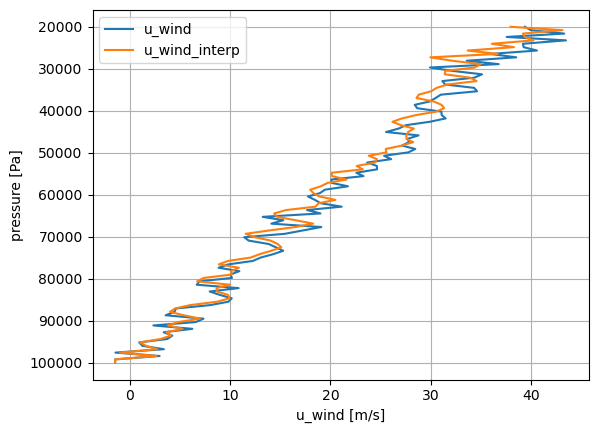

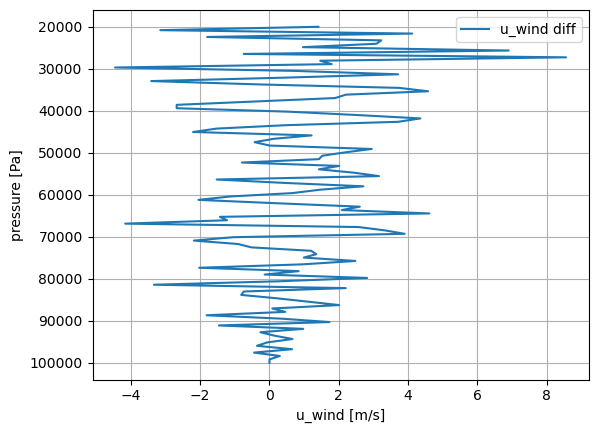

In [26]:
# Create pressure array from 1000 hPa to 200 hPa
pressure = np.linspace(1000, 200, num=100)
print('p: ',list(pressure))

# Create u and v wind components going from 0 to 40 m/s
u_wind = np.linspace(0, 40, num=100)
u_wind = list(np.array(u_wind) + (np.random.randn(100, )*2))

np.random.randn(100)
v_wind = np.linspace(0, 40, num=100)

# Create temperature array, 10K warmer at the surface and cooling with a lapse rate of -5 K/km
surface_temperature = 288.15 + 10  # Standard surface temperature is 288.15K, adding 10K
lapse_rate = -5 / 1000  # Lapse rate in K/m

z = [p_to_z_ifs(i)/9.80665 for i in pressure]
print('z: ', z)
temperature = surface_temperature + lapse_rate * np.array(z)
print('T: ', list(temperature))
p = [z_to_p_ifs(i*9.80665) for i in z]
print('p: ', p)

p_poly = compute_pressure_profile(temperature, z, p[0])
calculate_pressure_layered
print('pp:', list(p_poly))

plt.plot(u_wind, p, label='u_wind')
plt.plot( np.flip(np.interp(np.flip(p_poly), np.flip(p), np.flip(u_wind))), p, label='u_wind_interp')
plt.gca().invert_yaxis()
plt.xlabel('u_wind [m/s]')
plt.ylabel('pressure [Pa]') 
plt.legend()
plt.grid()
plt.show()
plt.close()

plt.plot( u_wind - np.flip(np.interp(np.flip(p_poly), np.flip(p), np.flip(u_wind))), p, label='u_wind diff')
plt.gca().invert_yaxis()
plt.xlabel('u_wind [m/s]')
plt.ylabel('pressure [Pa]') 
plt.legend()
plt.grid()
plt.show()
plt.close()


In [15]:
np.flip(p)

array([ 20000.        ,  20808.08080808,  21616.16161616,  22424.24242424,
        23232.32323232,  24040.4040404 ,  24848.48484848,  25656.56565657,
        26464.64646465,  27272.72727273,  28080.80808081,  28888.88888889,
        29696.96969697,  30505.05050505,  31313.13131313,  32121.21212121,
        32929.29292929,  33737.37373737,  34545.45454545,  35353.53535354,
        36161.61616162,  36969.6969697 ,  37777.77777778,  38585.85858586,
        39393.93939394,  40202.02020202,  41010.1010101 ,  41818.18181818,
        42626.26262626,  43434.34343434,  44242.42424242,  45050.50505051,
        45858.58585859,  46666.66666667,  47474.74747475,  48282.82828283,
        49090.90909091,  49898.98989899,  50707.07070707,  51515.15151515,
        52323.23232323,  53131.31313131,  53939.39393939,  54747.47474747,
        55555.55555556,  56363.63636364,  57171.71717172,  57979.7979798 ,
        58787.87878788,  59595.95959596,  60404.04040404,  61212.12121212,
        62020.2020202 ,  

Potential Issues in Calculation

pilot_asc_piv.dropna(subset=117, inplace=True)
If 117 (geopotential height) has missing values, dropping them might cause inconsistencies when aligning with radiosonde data.
Consider checking whether the missing values are significant and handling them differently (e.g., filling with interpolation).

fg_depar@body Adjustment:
pilot_df_fg['observation_value'] = pilot_df_fg['observation_value'] - pilot_df_fg['fg_depar@body']
If fg_depar@body contains NaNs, this will introduce NaNs in observation_value. Ensure NaNs are handled properly before subtraction.

Interpolation Issues:
np.interp(z_pilot, z_rs, gp_rs):
If z_rs is not strictly increasing, np.interp may fail or produce incorrect results.
Check z_rs for duplicates or sort it before interpolation.

Logarithm Transformations:
pilot_asc_piv['z_coordinate'] = np.log(pilot_asc_piv['z_coordinate'])
If z_coordinate has zero or negative values, np.log will produce errors. Ensure all values are positive.

Pressure Profile Calculation:
p_poly = np.flip(compute_pressure_profile(T, pasc_reverse[117] / g, p_ifs[0]))
Ensure compute_pressure_profile correctly handles units and scaling.
pasc_reverse[117] / g: This assumes 117 is in geopotential height (m), but if it’s already in pressure levels, dividing by g may be incorrect.

Matching Between Radiosonde and Pilot Balloon:
best_match = pd.merge_asof(pilot_asc, rs_df_piv, on='date_time', direction='nearest', tolerance=pd.Timedelta('12H'))
Ensure date_time is properly sorted before merge_asof.
If no match is found within 12 hours, it might return NaNs. Consider adding a check for empty matches.

